In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
"""
group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]
"""

# A setting
building_num_A = [4, 10, 11, 12, 34, 40, 41, 42] # 8
checking_tag_A = ['4', "A", "A", '12', '34', '40', '41', '42']
model_paths_A = ["Archive/A/4_B.ckpt", "Archive/A/A.ckpt", "Archive/A/A.ckpt", "Archive/A/12_B.ckpt", "Archive/A/34_B.ckpt",
"Archive/A/40_B.ckpt", "Archive/A/41_B.ckpt", "Archive/A/42_B.ckpt"]

# B setting
building_num_B = [6, 7, 8, 13, 17, 18, 25, 26, 27, 35, 46, 47, 48, 53, 55, 56, 57] # 17
checking_tag_B = ['B' for i in range(17)]
model_paths_B = ['Archive/B/B.ckpt' for i in range(17)]

# C setting
building_num_C = [1, 3, 9, 31, 32, 33] # 6
checking_tag_C = ['C' for i in range(6)]
model_paths_C = ['Archive/C/C.ckpt' for i in range(6)]

# D setting
building_num_D = [2, 14, 15, 22, 23, 29, 37, 38, 39, 43, 44, 45, 52, 54, 58] # 15
checking_tag_D = ['D' for i in range(15)]
model_paths_D = ['Archive/D/D.ckpt' for i in range(15)]

# E setting
building_num_E = [5, 16, 19, 20, 21, 24, 28, 30, 36, 49, 50, 51, 59, 60] # 14
checking_tag_E = ['E' for i in range(14)]
model_paths_E = ['Archive/E/E.ckpt' for i in range(14)]

In [3]:
checking_tag_E[12] = "59"
model_paths_E[12] = "Archive/E/59_B.ckpt"

In [4]:
building_num = building_num_A + building_num_B + building_num_C + building_num_D + building_num_E
checking_tag = checking_tag_A + checking_tag_B + checking_tag_C + checking_tag_D + checking_tag_E
model_paths = model_paths_A + model_paths_B + model_paths_C + model_paths_D + model_paths_E

input_length = 168
output_length = 24

show_graph = True

random_choice = 2 # random.randrange(2,13)

In [5]:
data_paths = []
for i in range(len(building_num)):
    if checking_tag[i].isdigit():
        data_paths.append(f"Refined_Data/Seperated_Data/{checking_tag[i]}.csv")
    else:
        data_paths.append(f"Refined_Data/Grouped_Data/{checking_tag[i]}.csv")

In [6]:
start_point = -168 * random_choice - 1
duration = 168

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

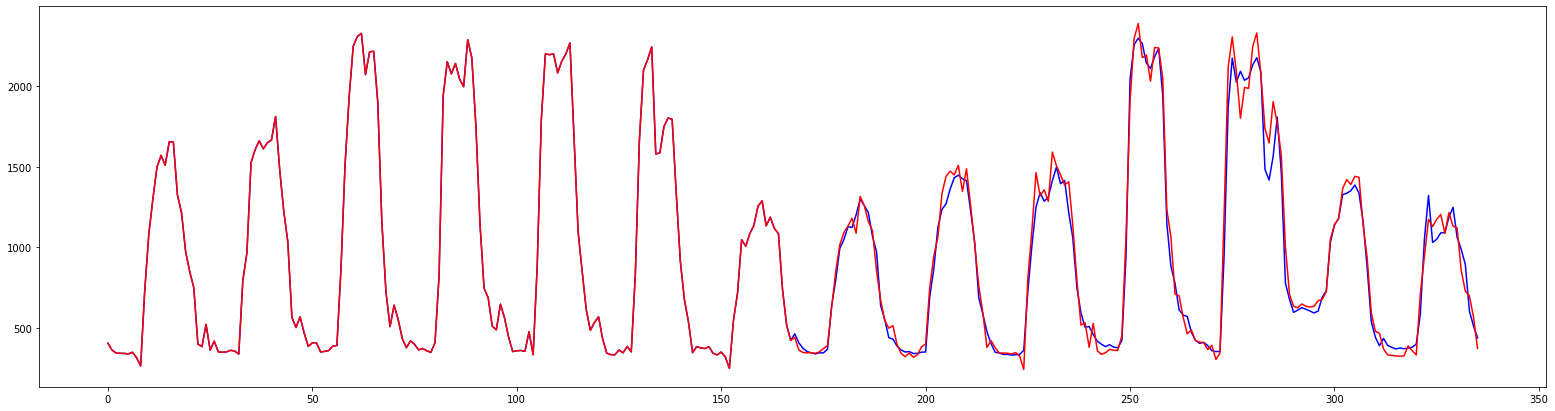

now : 4, sMAPE score : 7.589991757093719


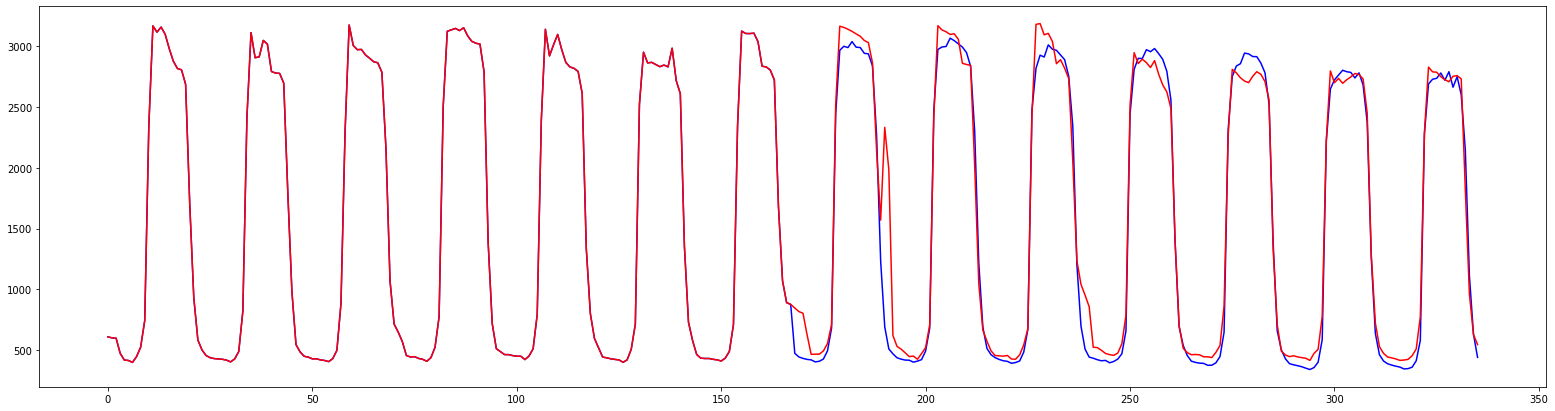

now : 10, sMAPE score : 11.816288744844604


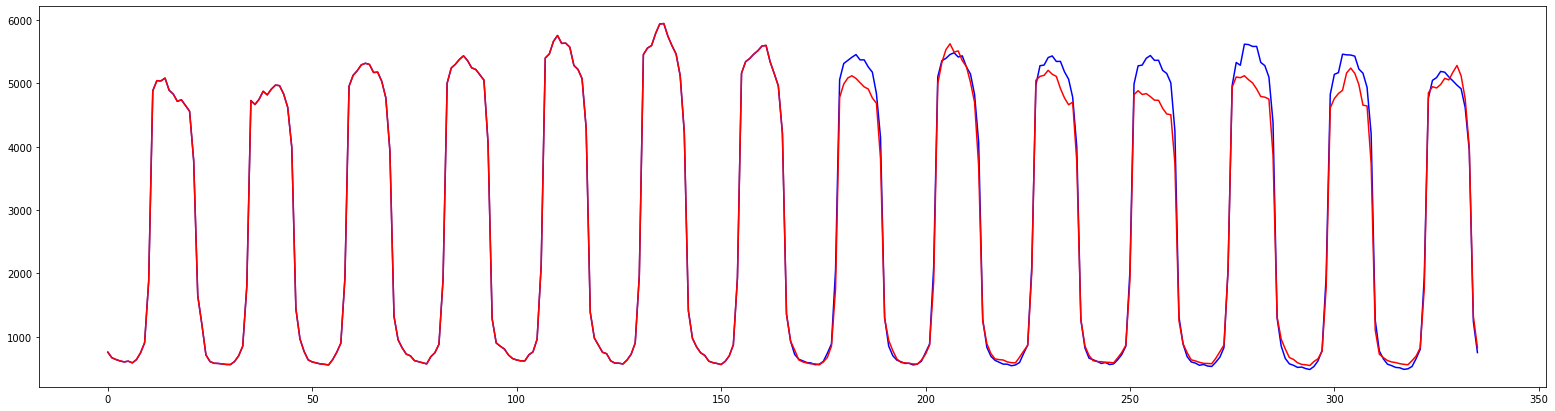

now : 11, sMAPE score : 6.328478188813635


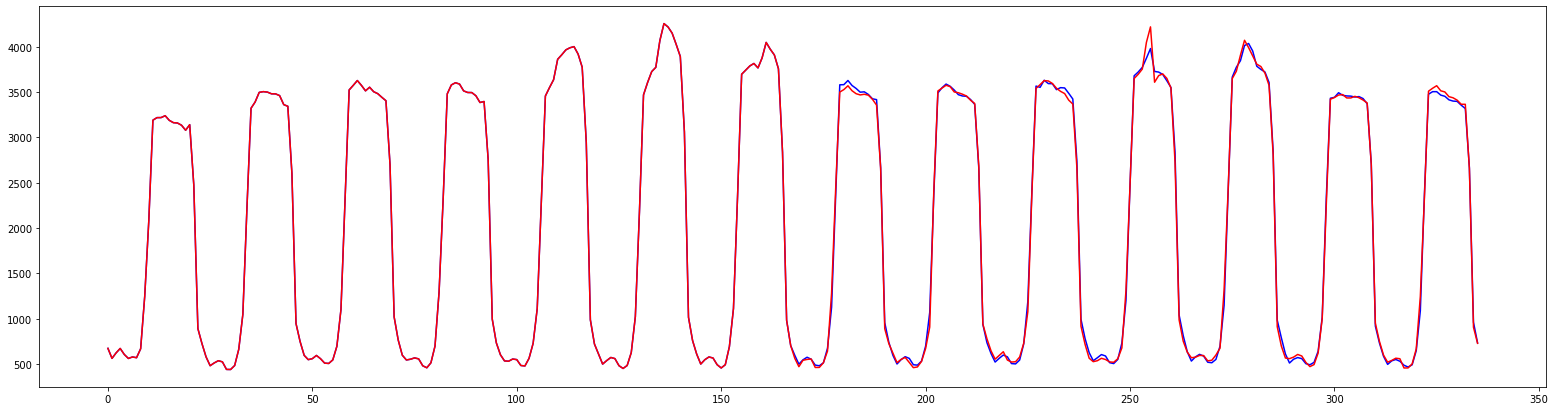

now : 12, sMAPE score : 2.983924125522385


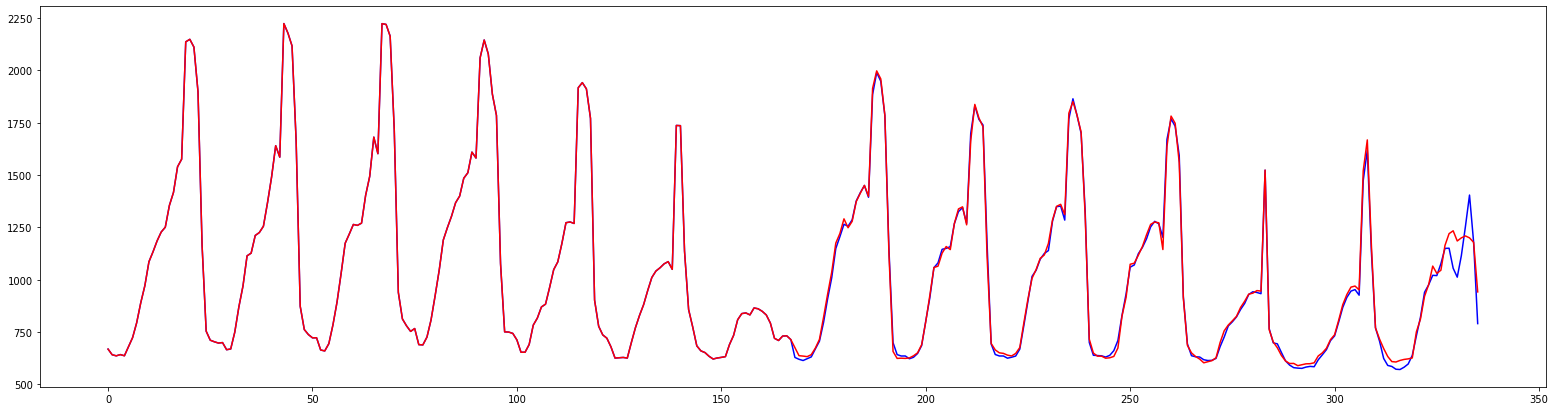

now : 34, sMAPE score : 2.091254111444771


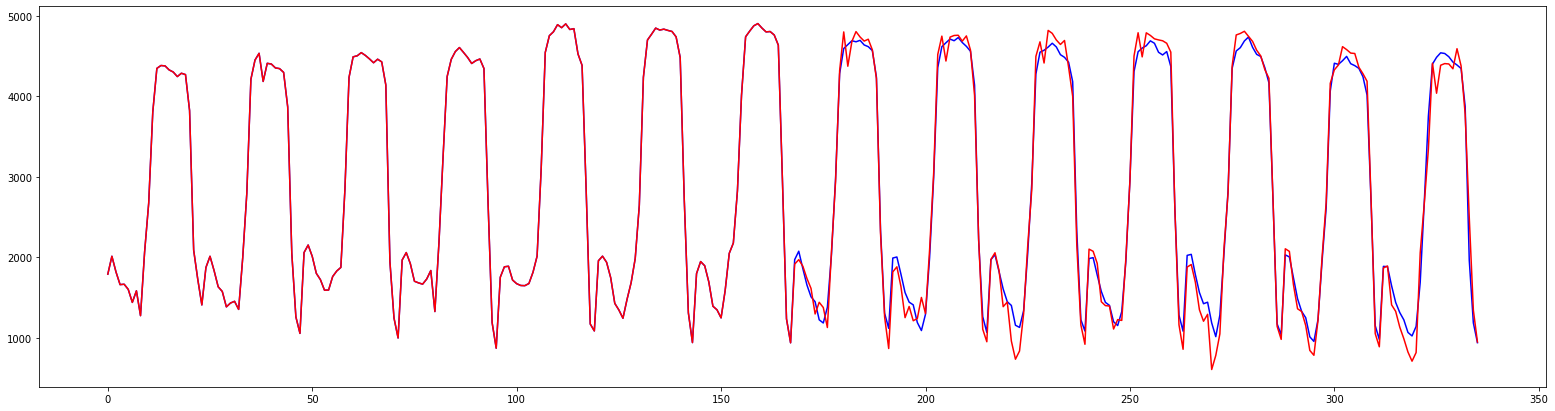

now : 40, sMAPE score : 7.029093033025488


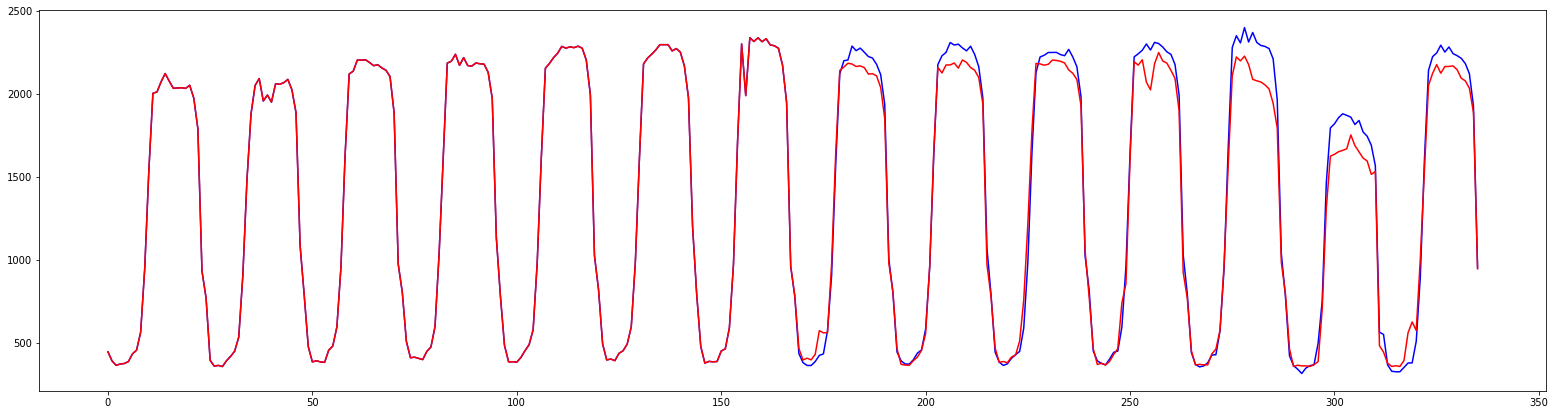

now : 41, sMAPE score : 6.436561865729861


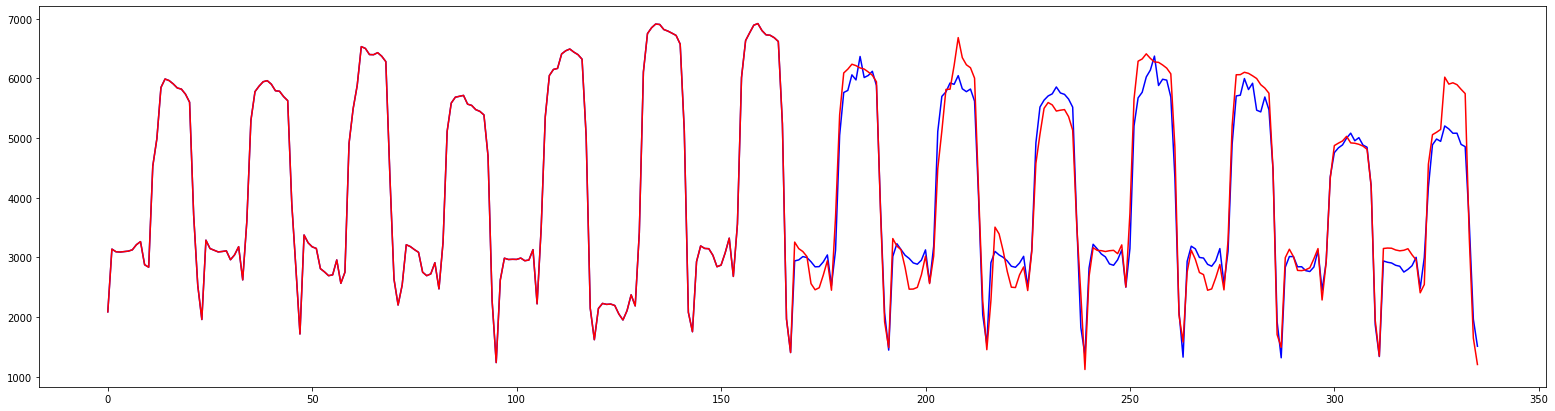

now : 42, sMAPE score : 6.6581639611146475


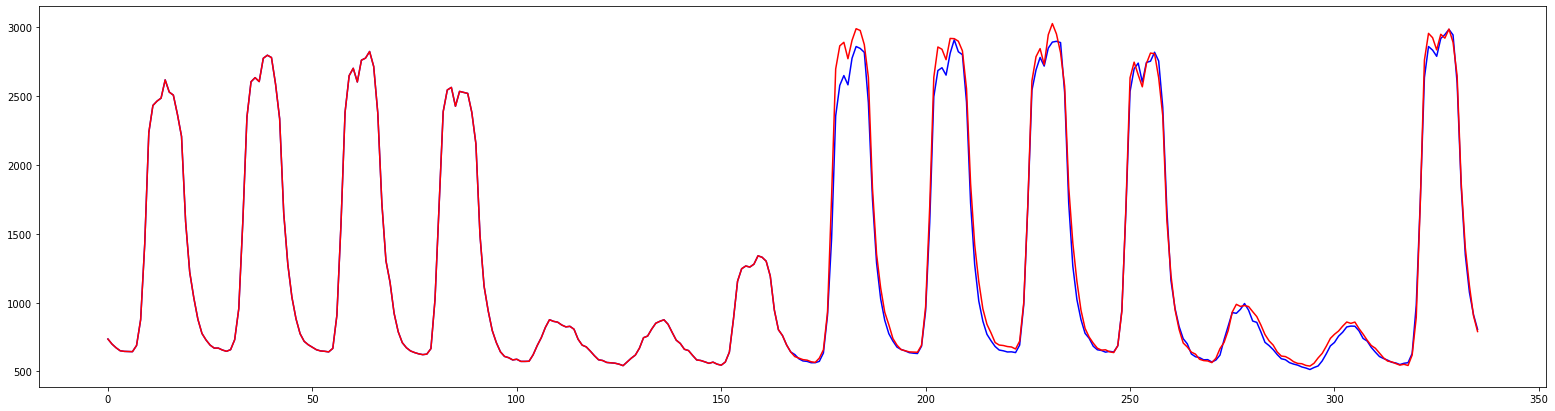

now : 6, sMAPE score : 3.836021911781914


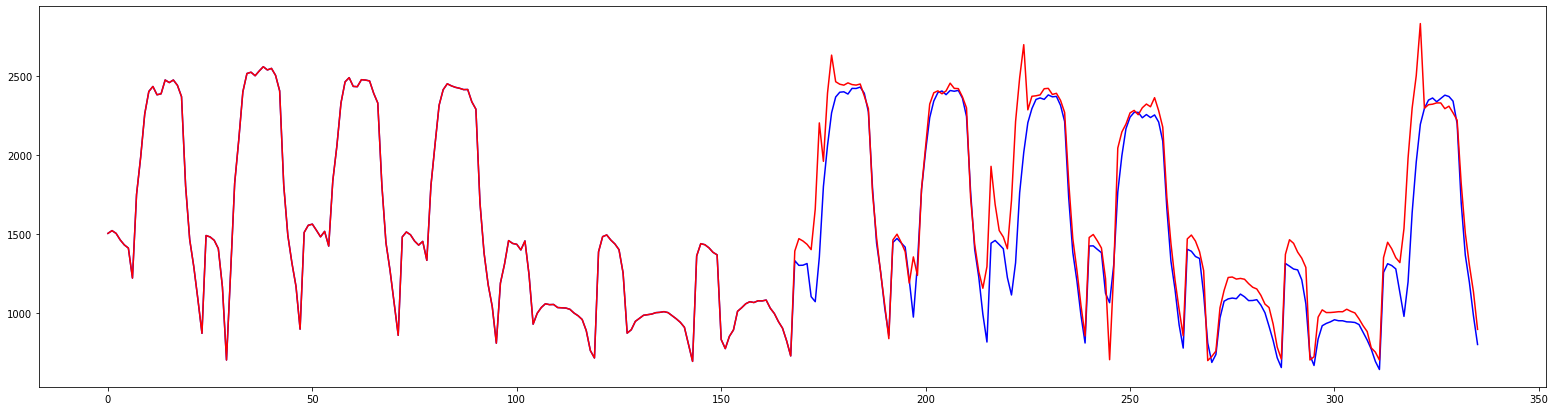

now : 7, sMAPE score : 8.544954812323347


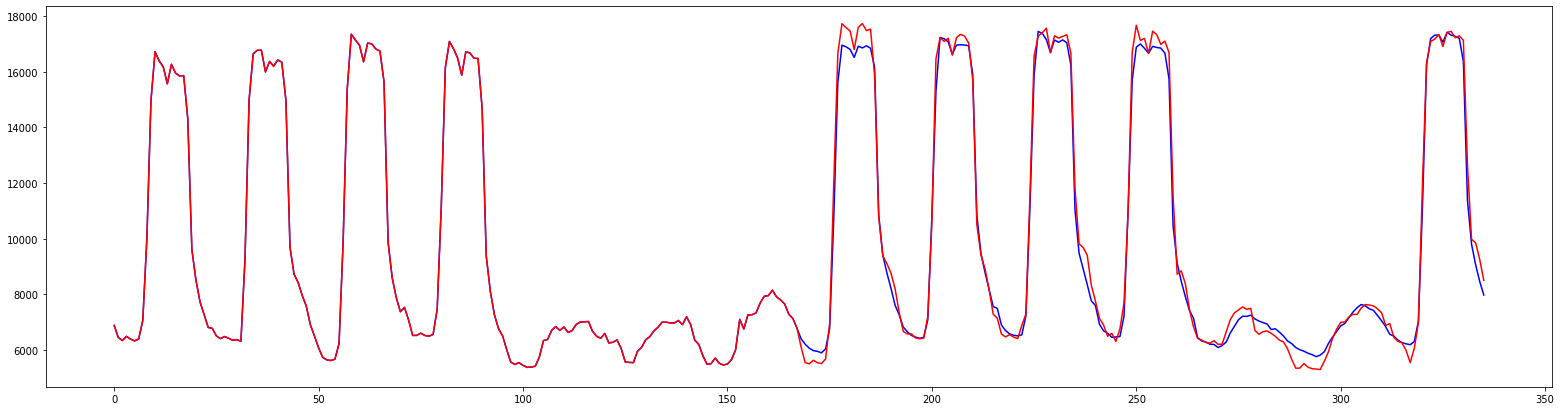

now : 8, sMAPE score : 3.529428955508637


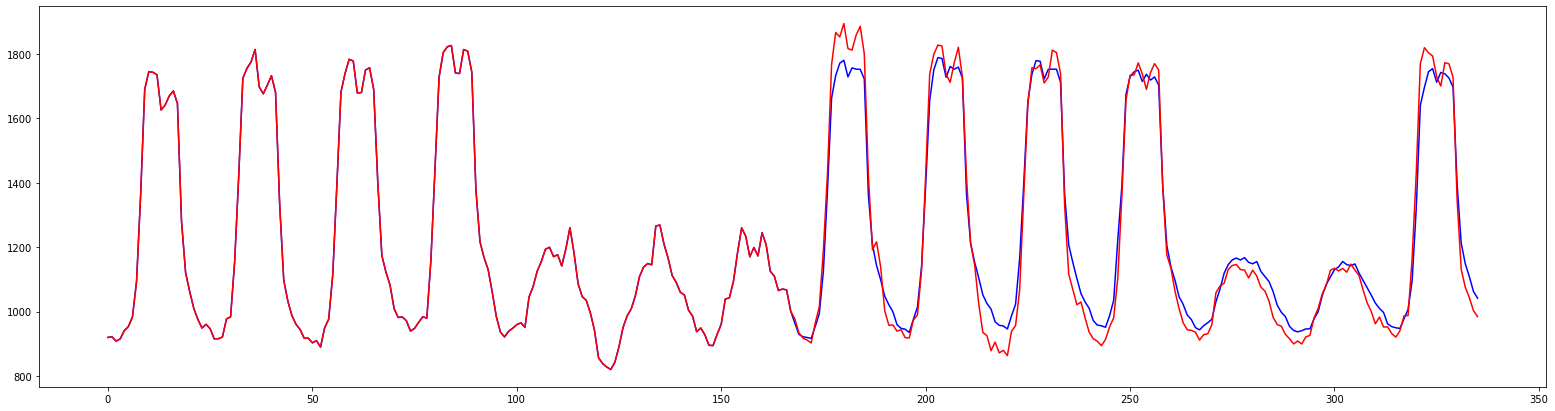

now : 13, sMAPE score : 3.552262632205313


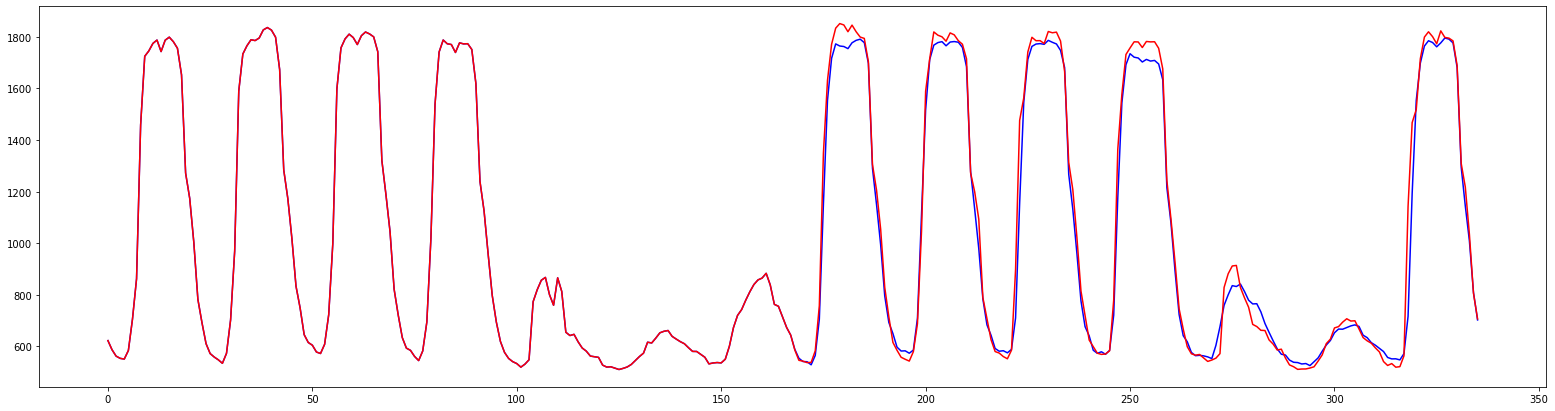

now : 17, sMAPE score : 3.85328390866175


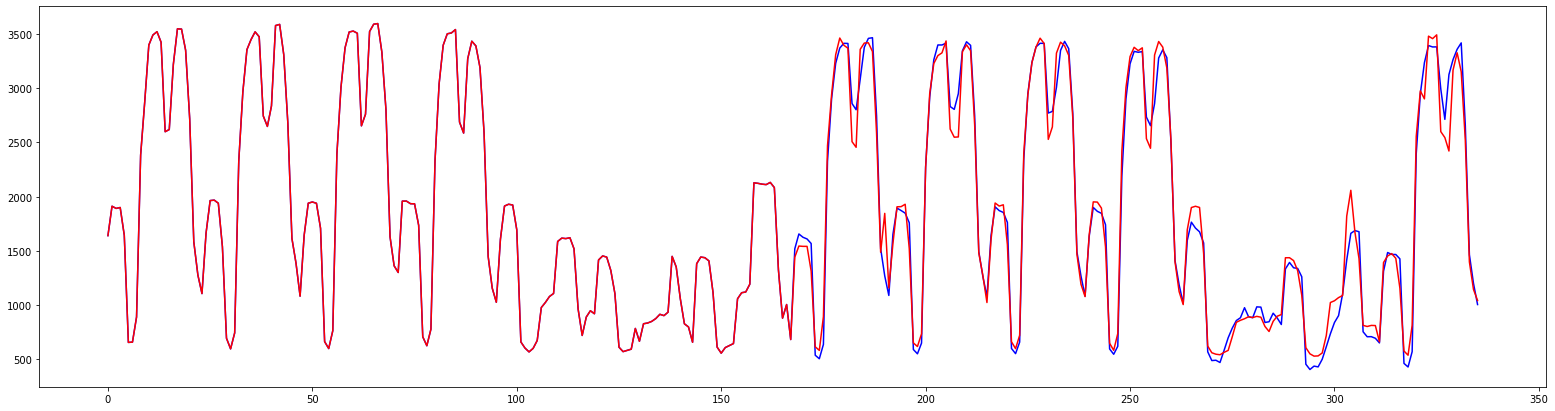

now : 18, sMAPE score : 7.643988036663278


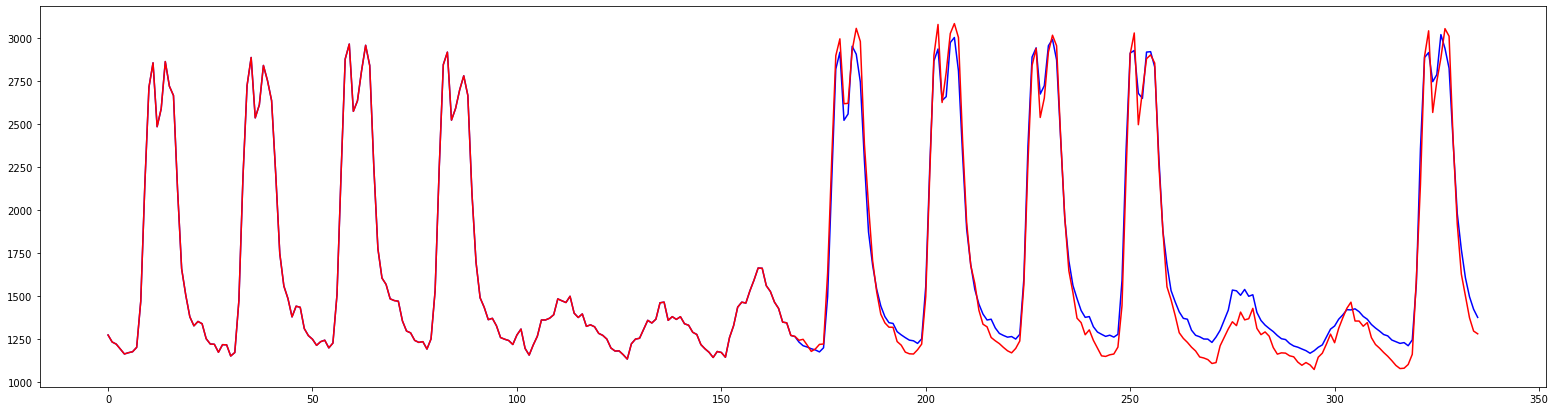

now : 25, sMAPE score : 5.200844957645447


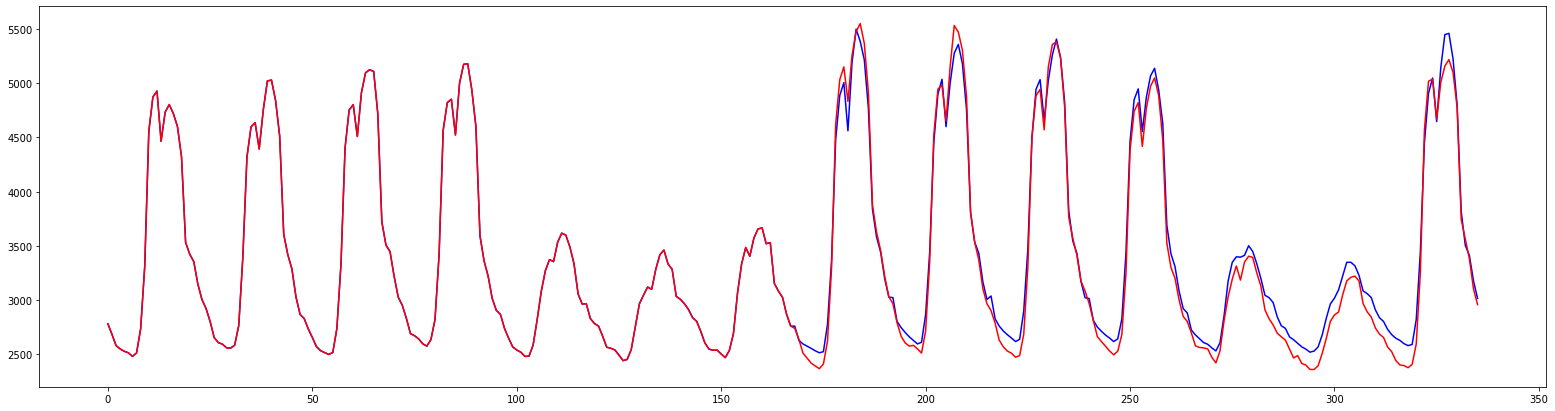

now : 26, sMAPE score : 3.426811568673974


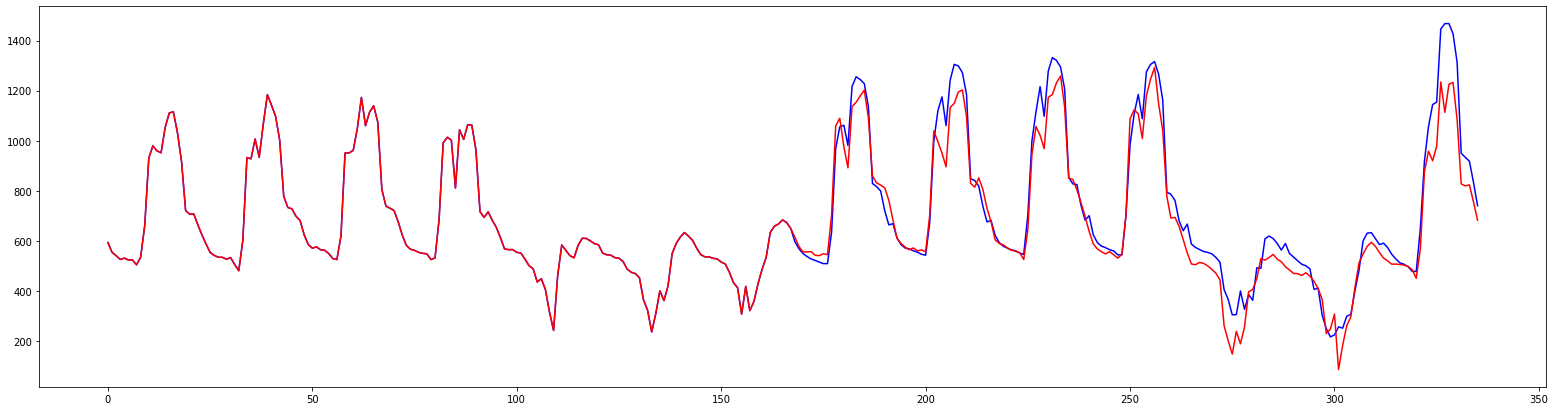

now : 27, sMAPE score : 9.62615588269021


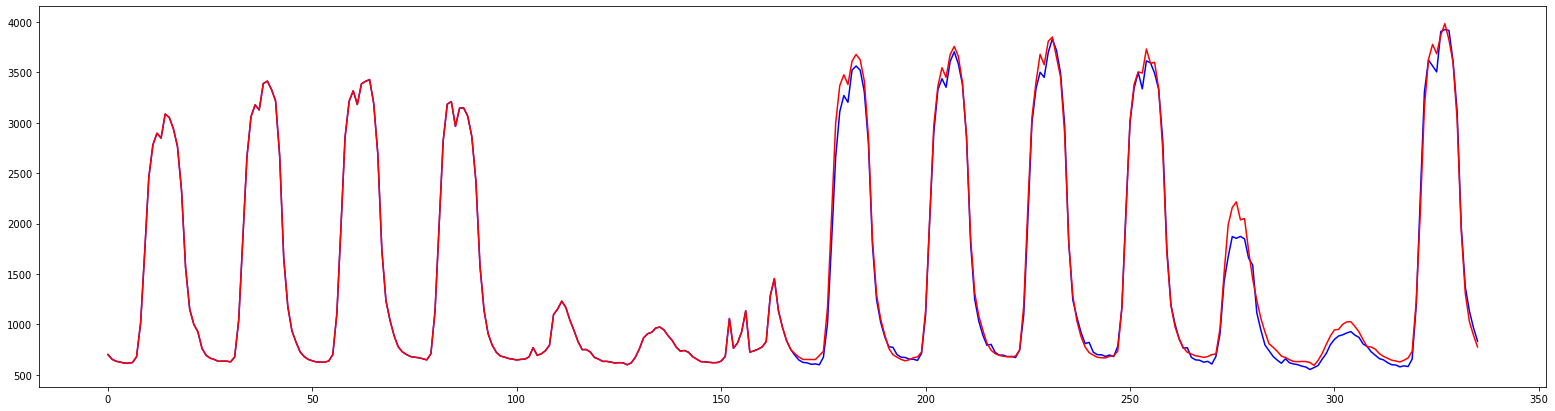

now : 35, sMAPE score : 5.255056522004938


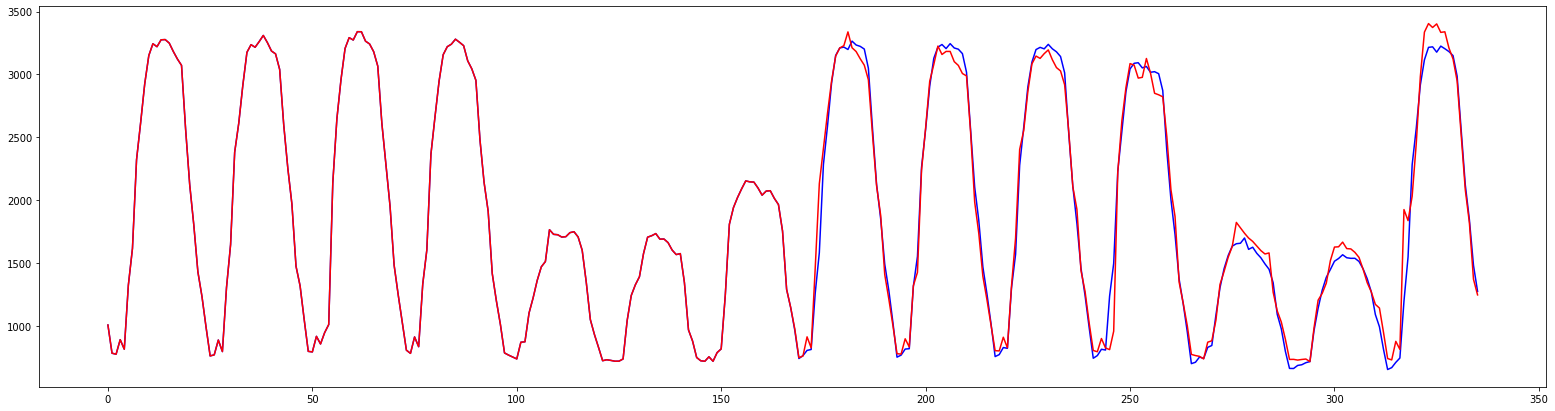

now : 46, sMAPE score : 4.921653698599859


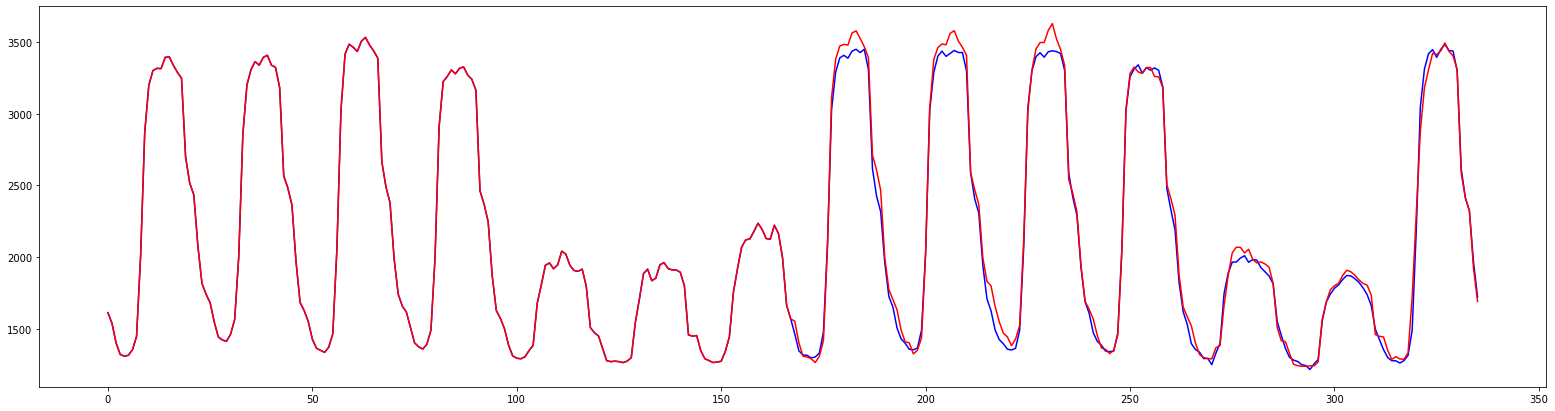

now : 47, sMAPE score : 2.451812229190282


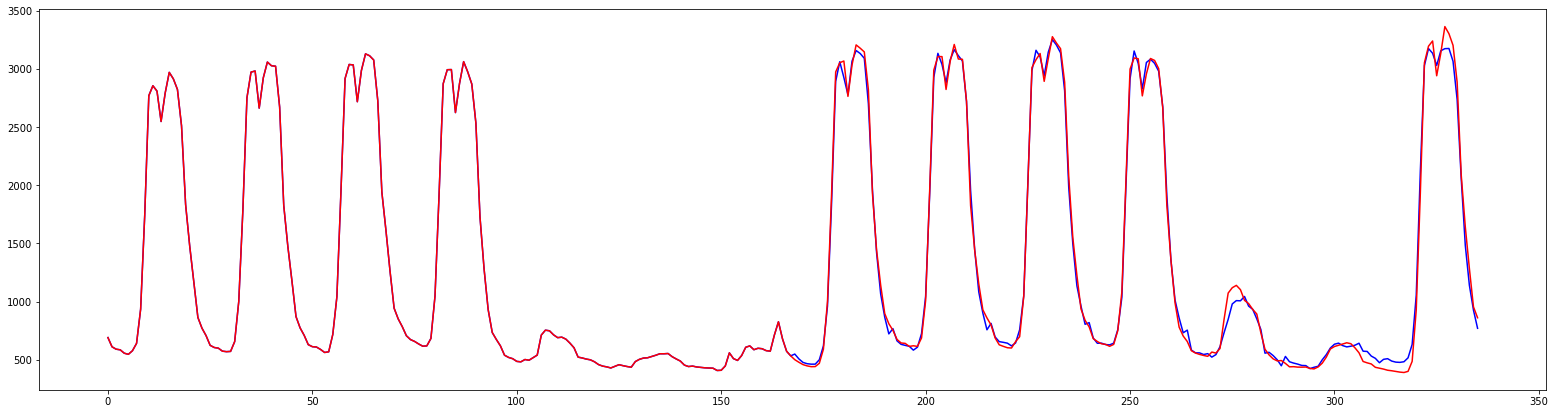

now : 48, sMAPE score : 5.099931984804866


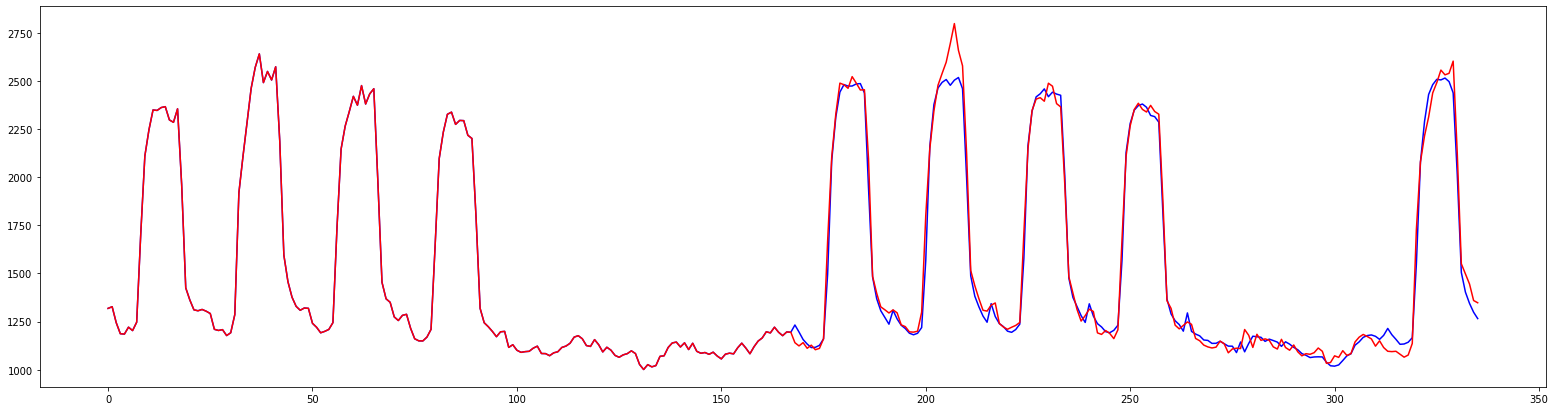

now : 53, sMAPE score : 2.734209690719839


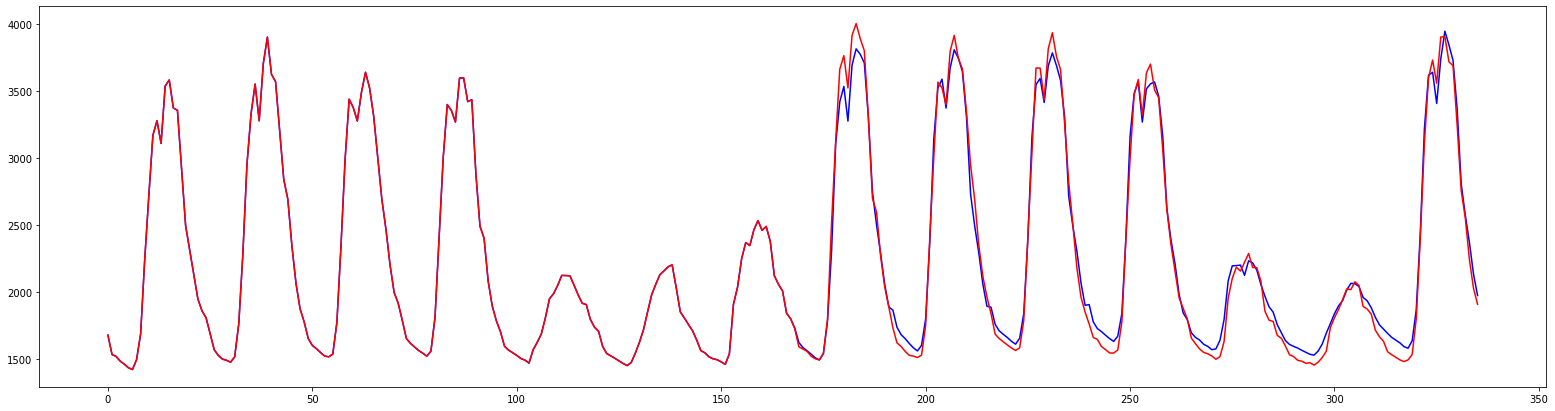

now : 55, sMAPE score : 3.458083132326683


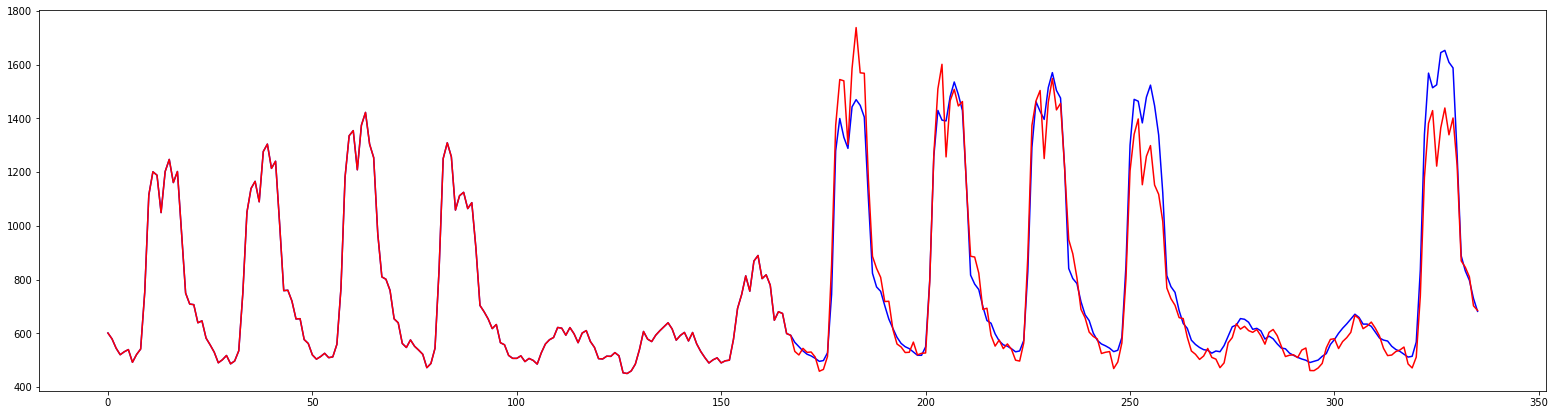

now : 56, sMAPE score : 5.913475122914479


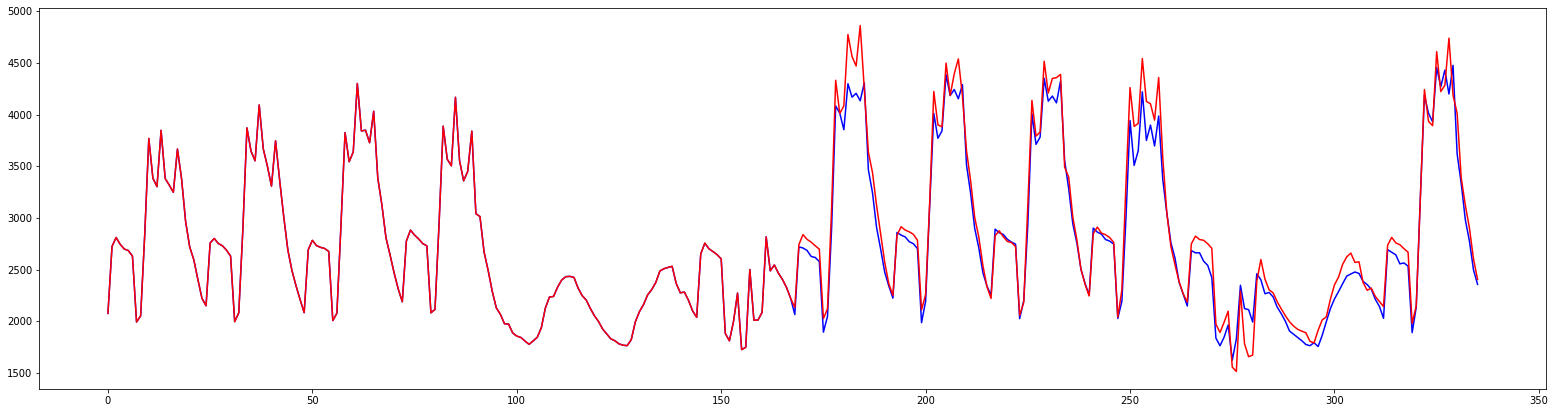

now : 57, sMAPE score : 4.281647421352869


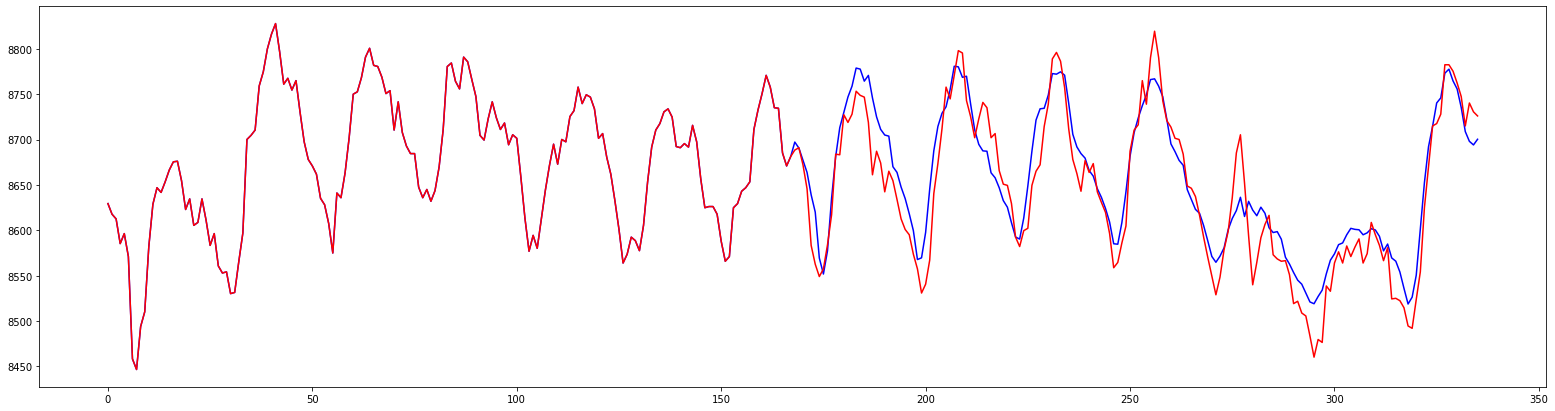

now : 1, sMAPE score : 0.28554094981313666


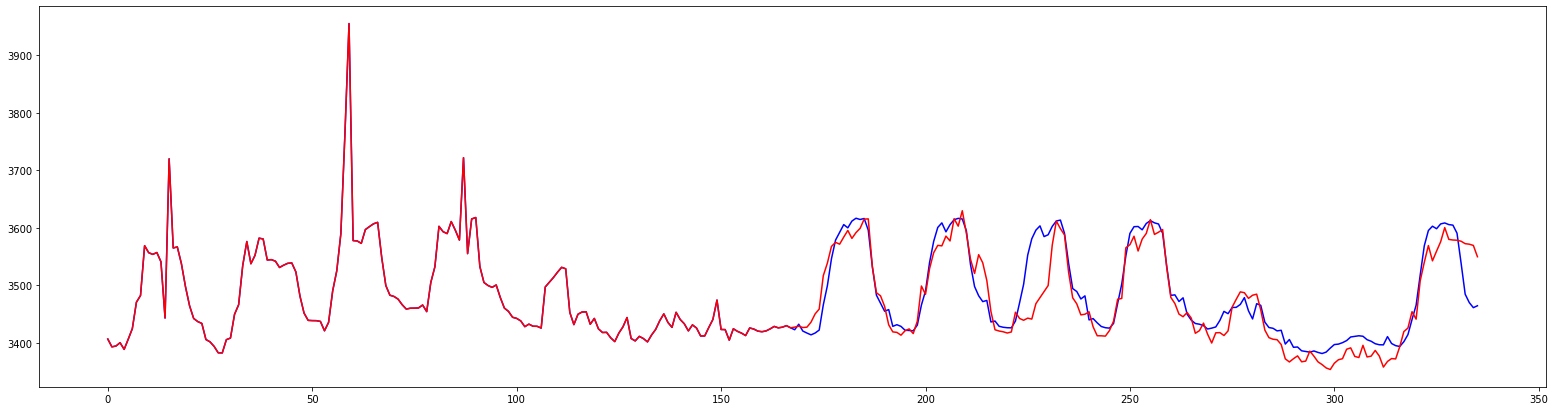

now : 3, sMAPE score : 0.7005918643987181


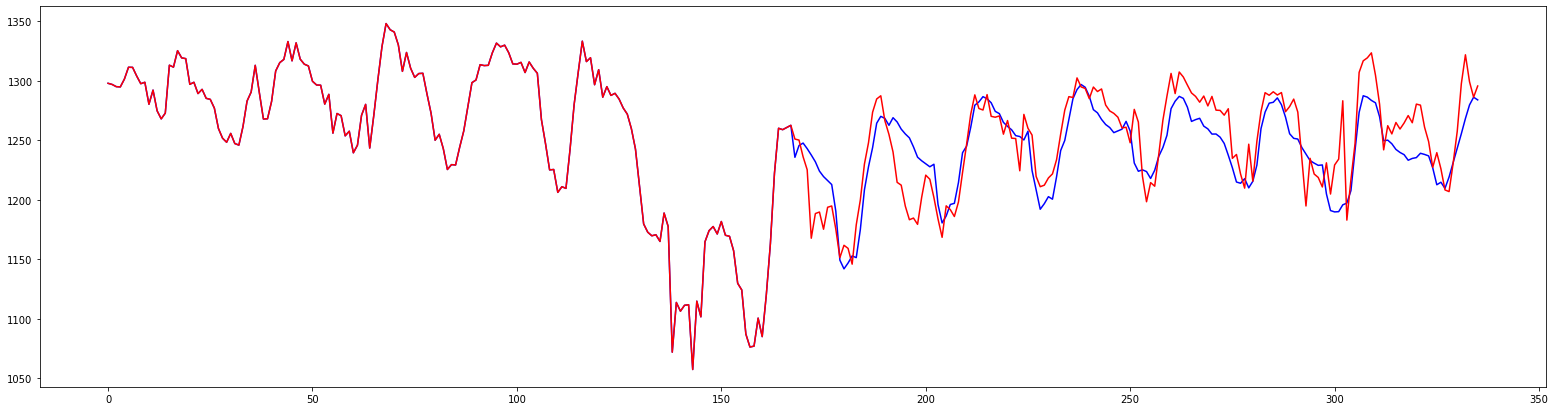

now : 9, sMAPE score : 1.565776085420771


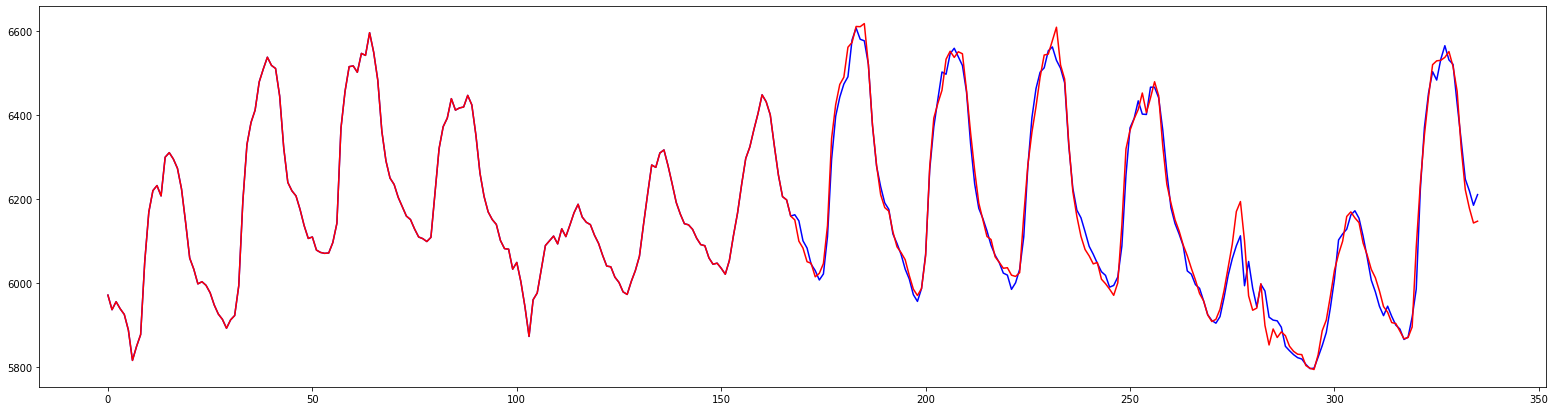

now : 31, sMAPE score : 0.3488600670358327


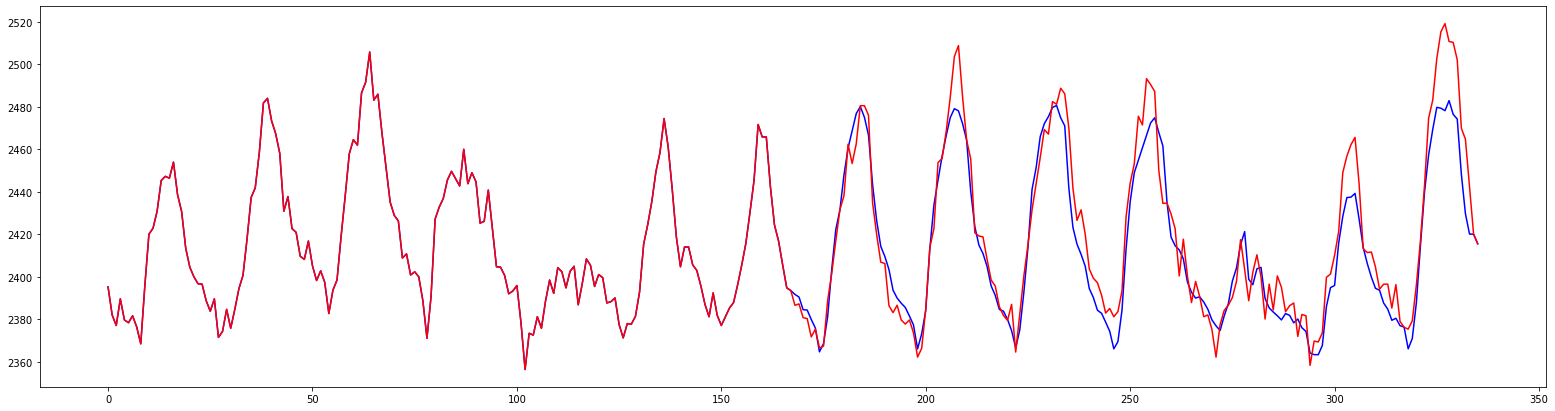

now : 32, sMAPE score : 0.39250464572716326


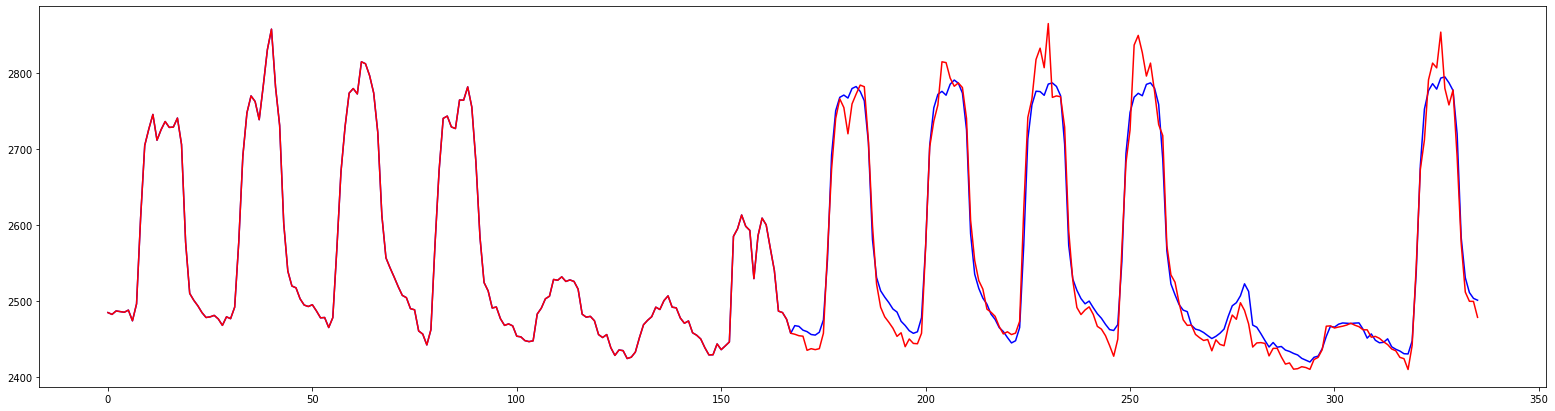

now : 33, sMAPE score : 0.6140045322604851


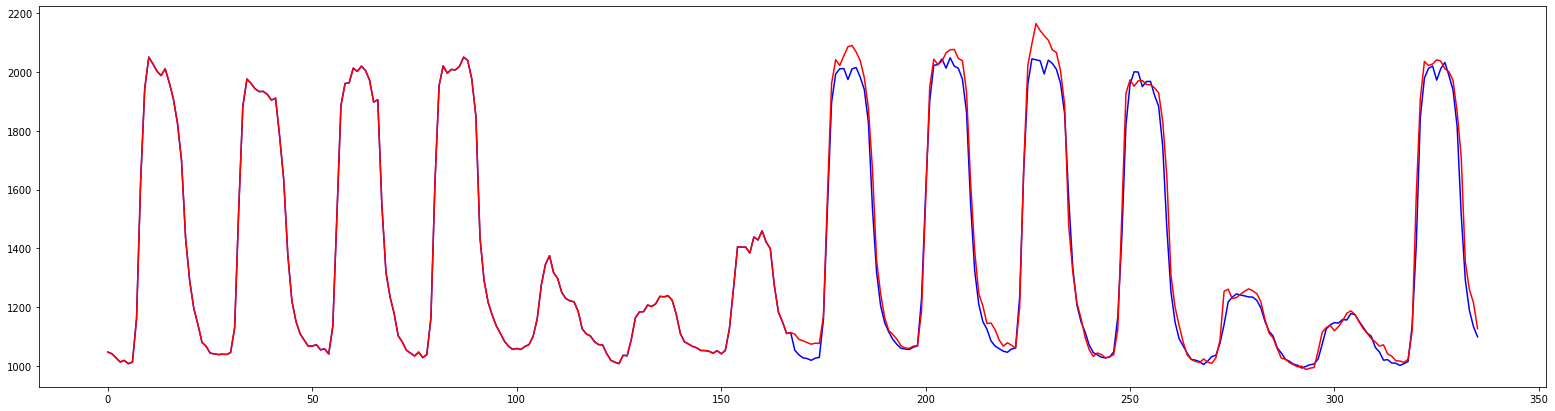

now : 2, sMAPE score : 2.344917270140164


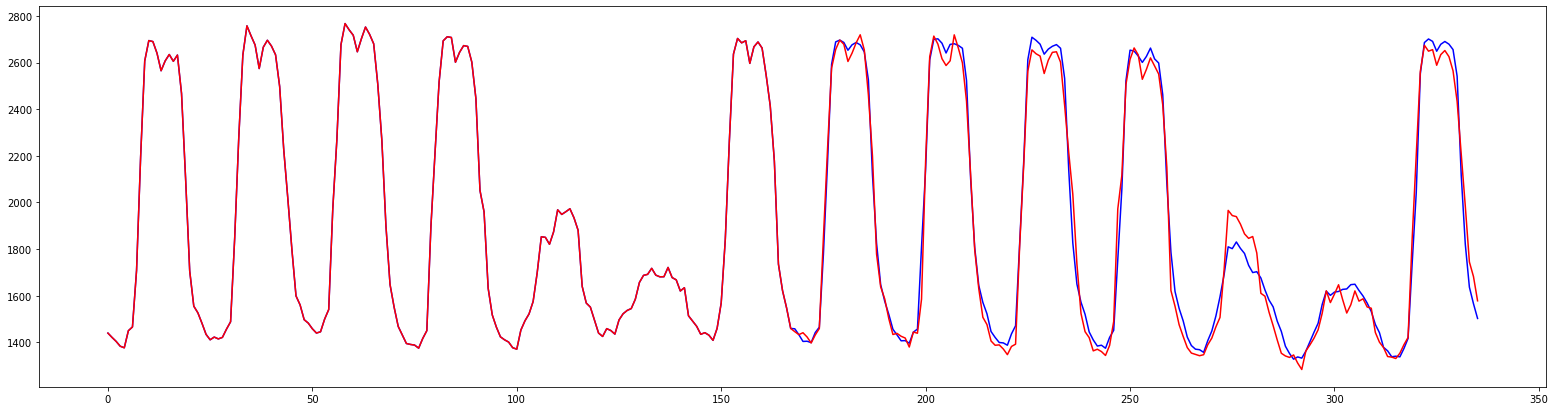

now : 14, sMAPE score : 2.625416001342092


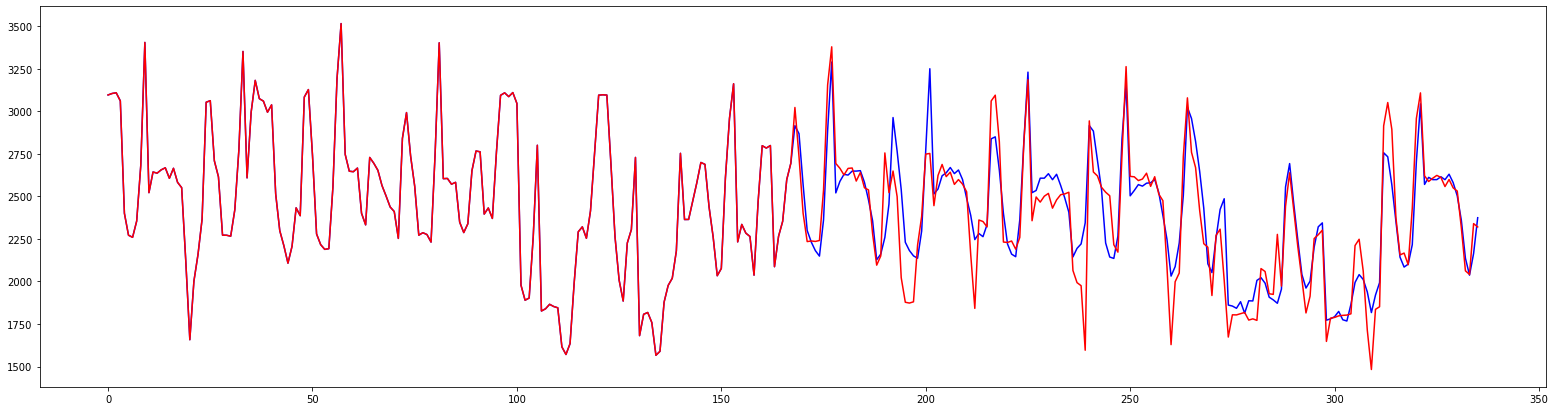

now : 15, sMAPE score : 5.15712433864981


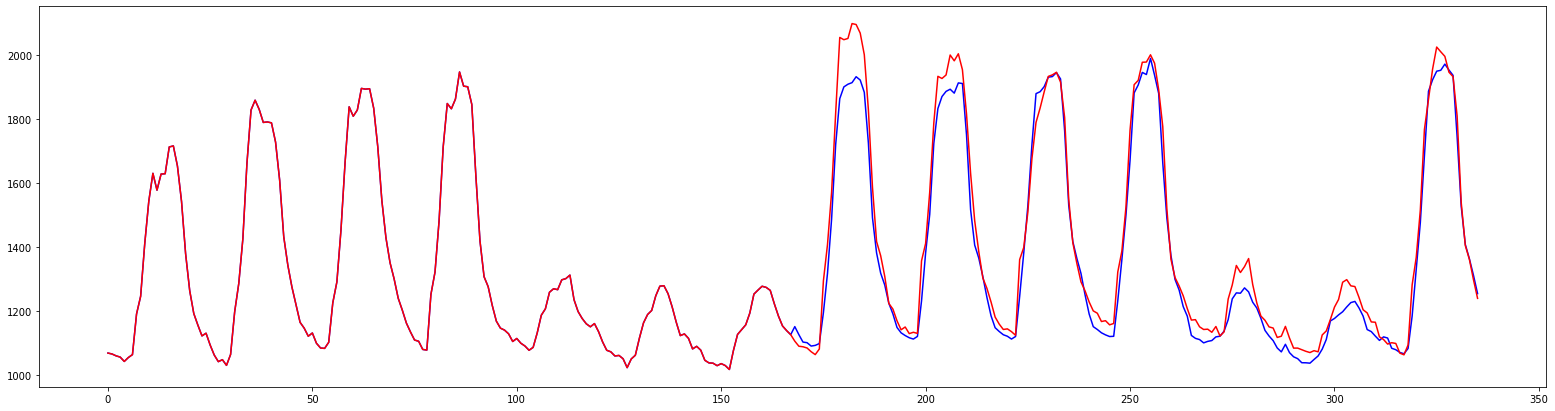

now : 22, sMAPE score : 3.070961938444086


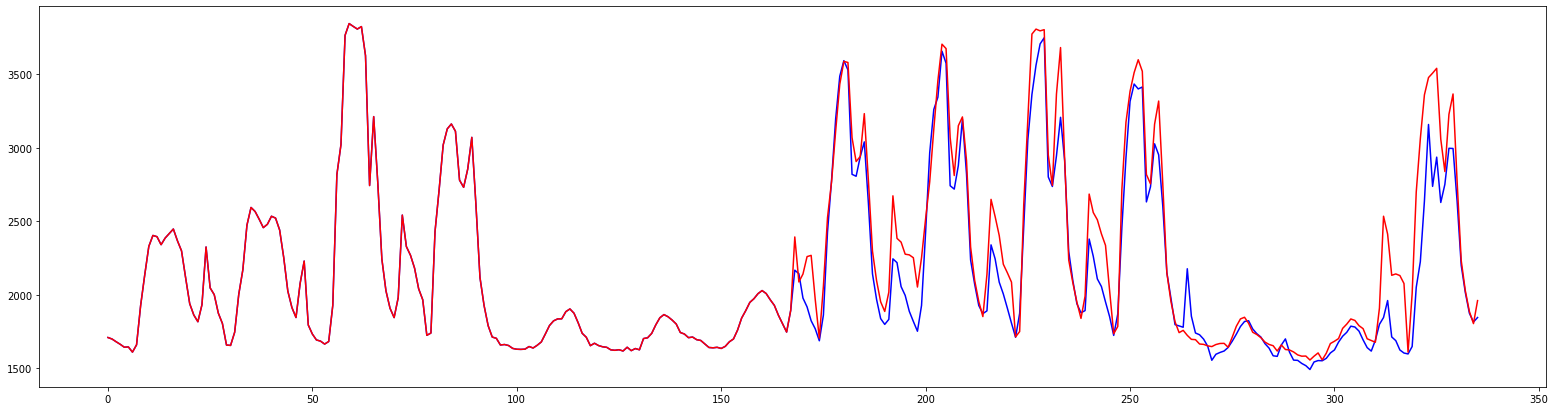

now : 23, sMAPE score : 6.928604726511244


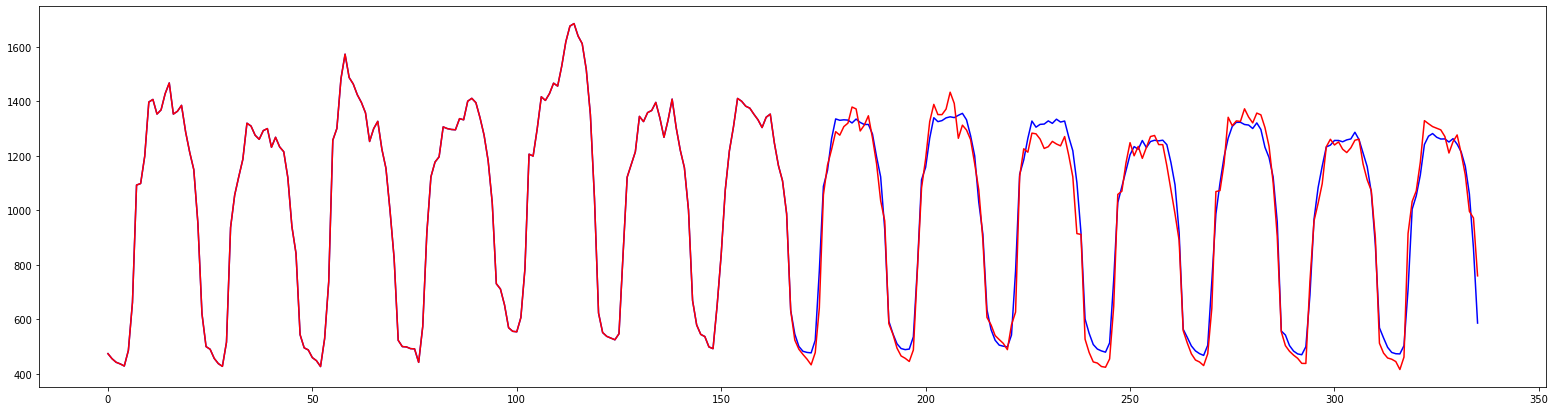

now : 29, sMAPE score : 4.9648628053312045


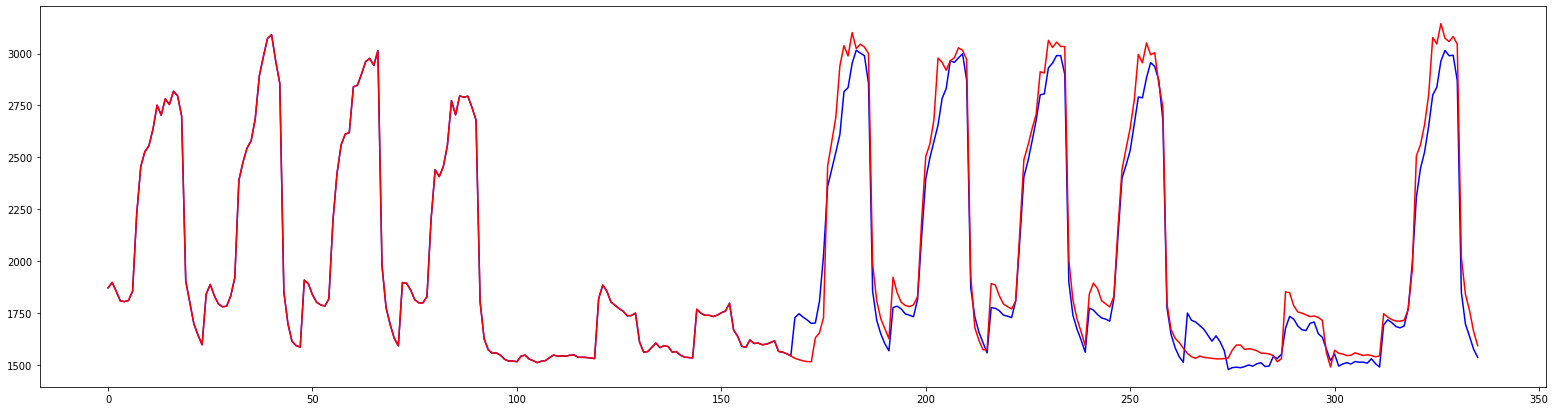

now : 37, sMAPE score : 4.303591460552155


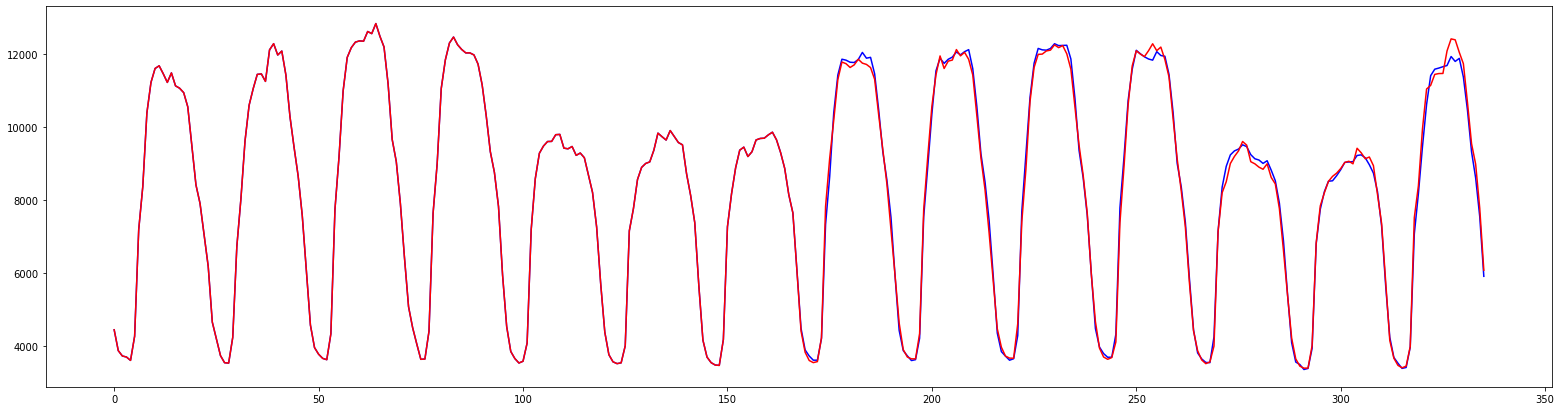

now : 38, sMAPE score : 1.7542403177757468


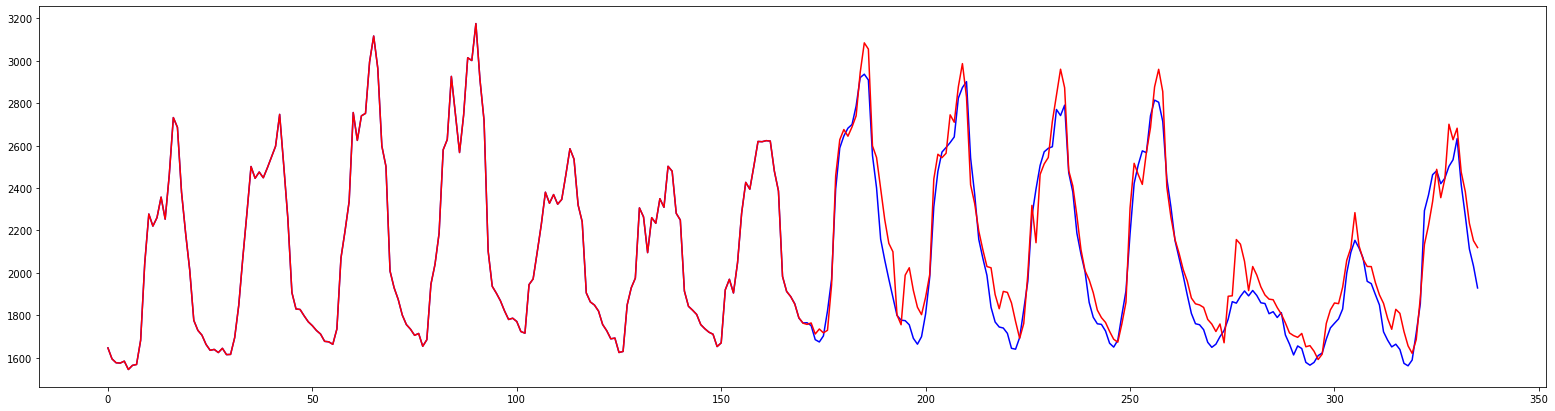

now : 39, sMAPE score : 4.02458360369572


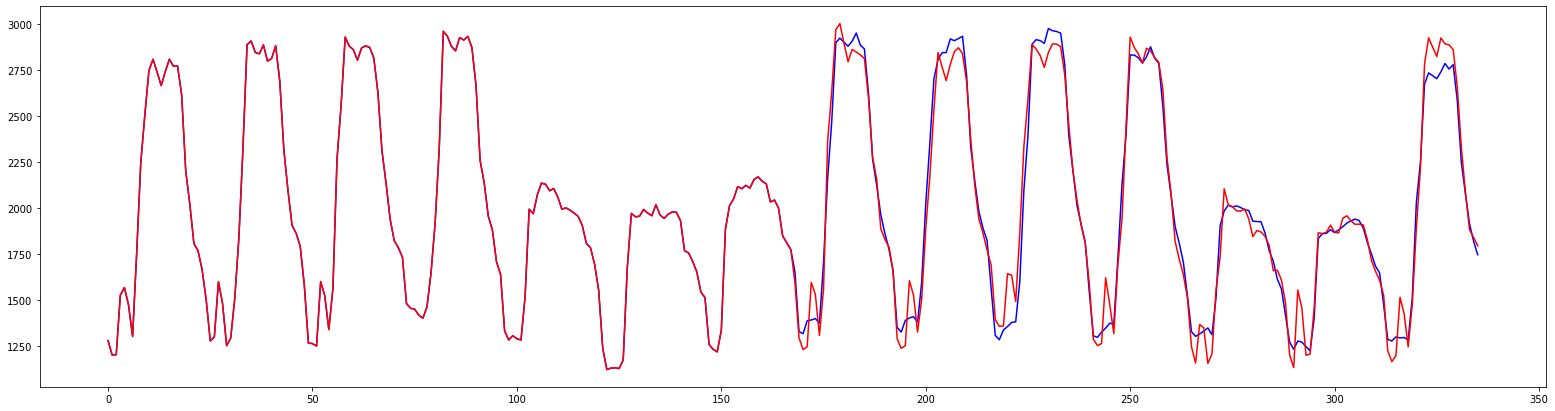

now : 43, sMAPE score : 4.199512574340551


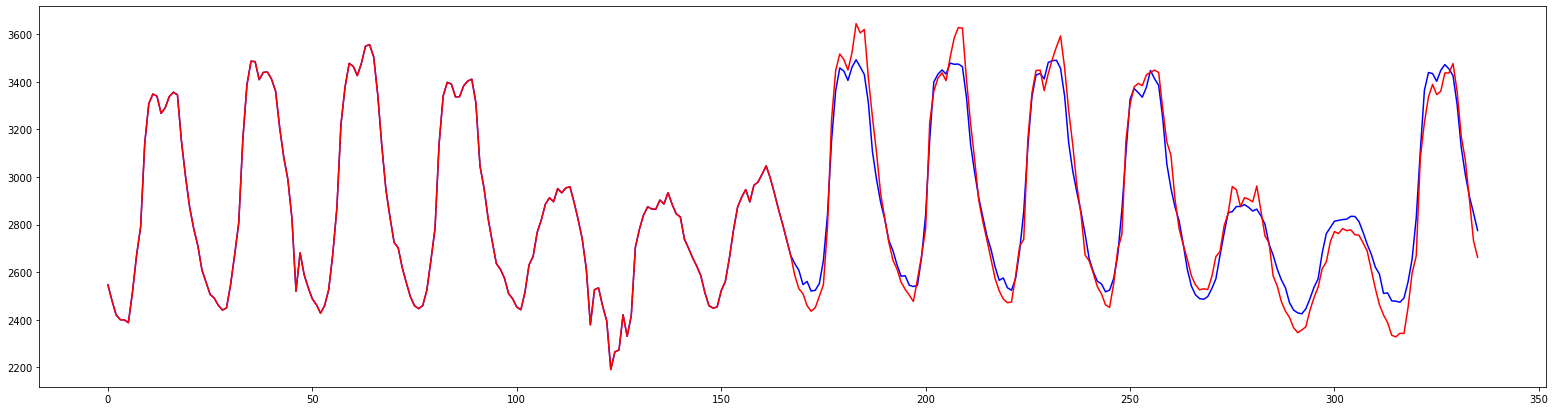

now : 44, sMAPE score : 2.137229746531236


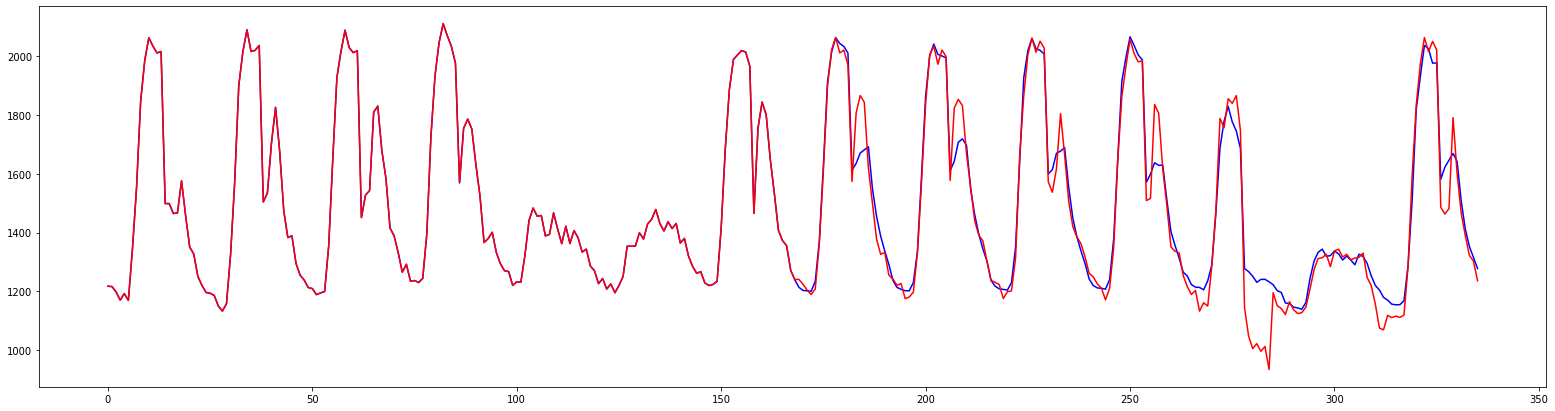

now : 45, sMAPE score : 3.370369499611591


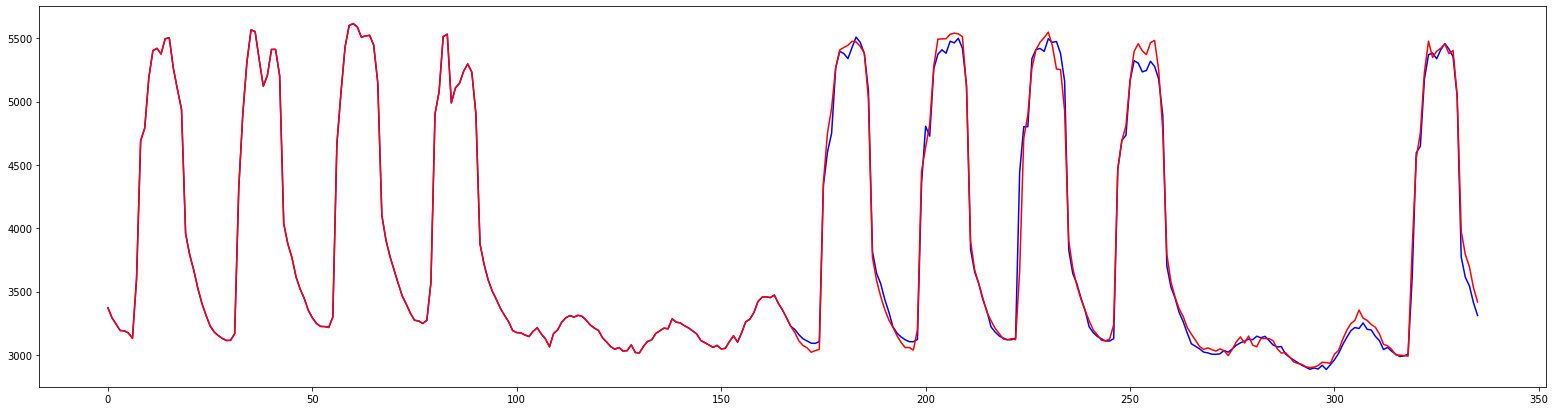

now : 52, sMAPE score : 1.4467513097578755


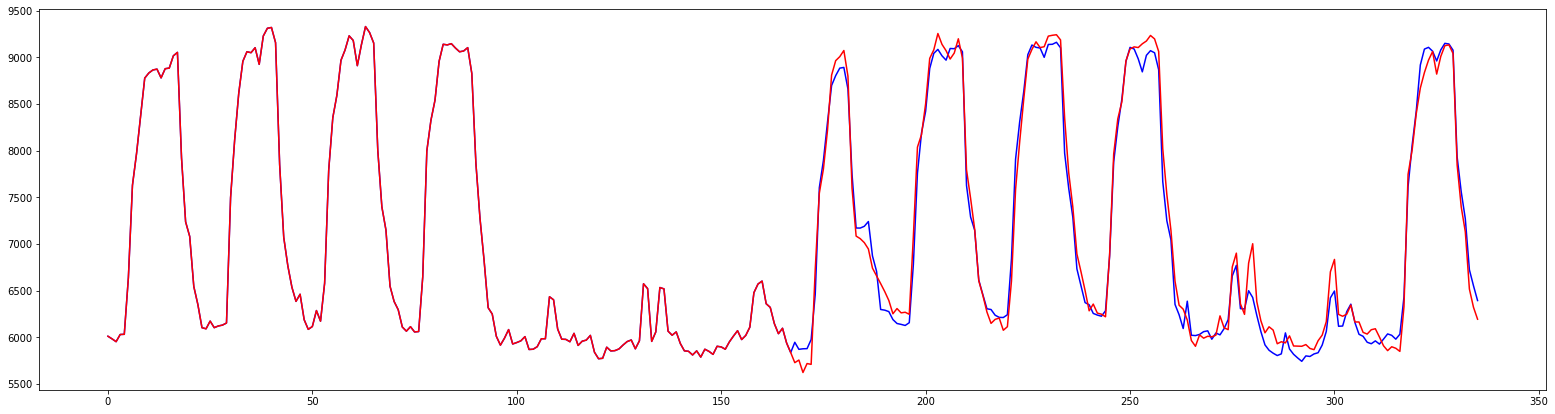

now : 54, sMAPE score : 1.8143864812622776


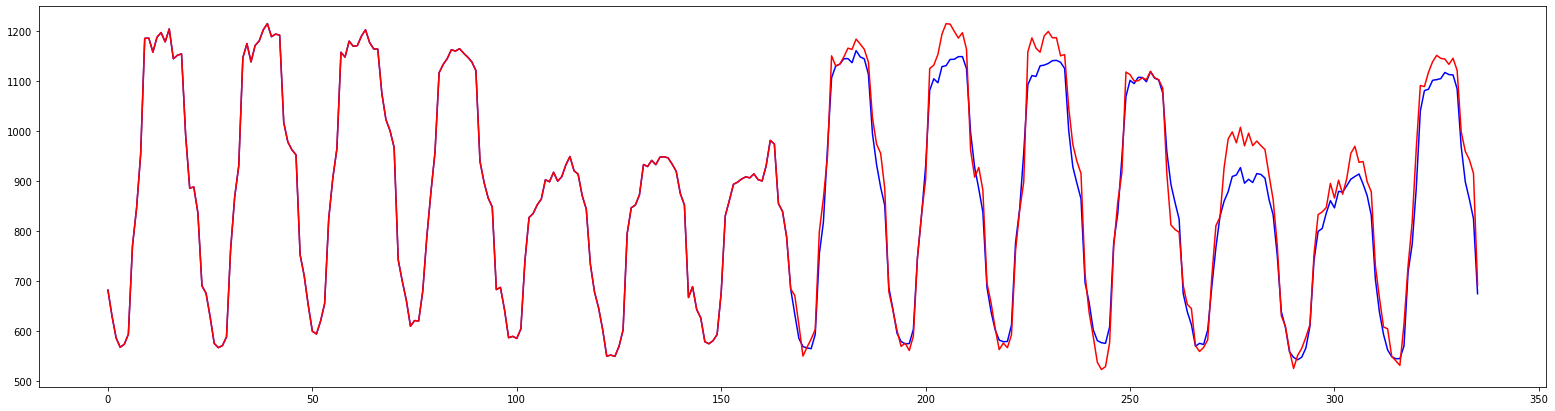

now : 58, sMAPE score : 3.571706460813389


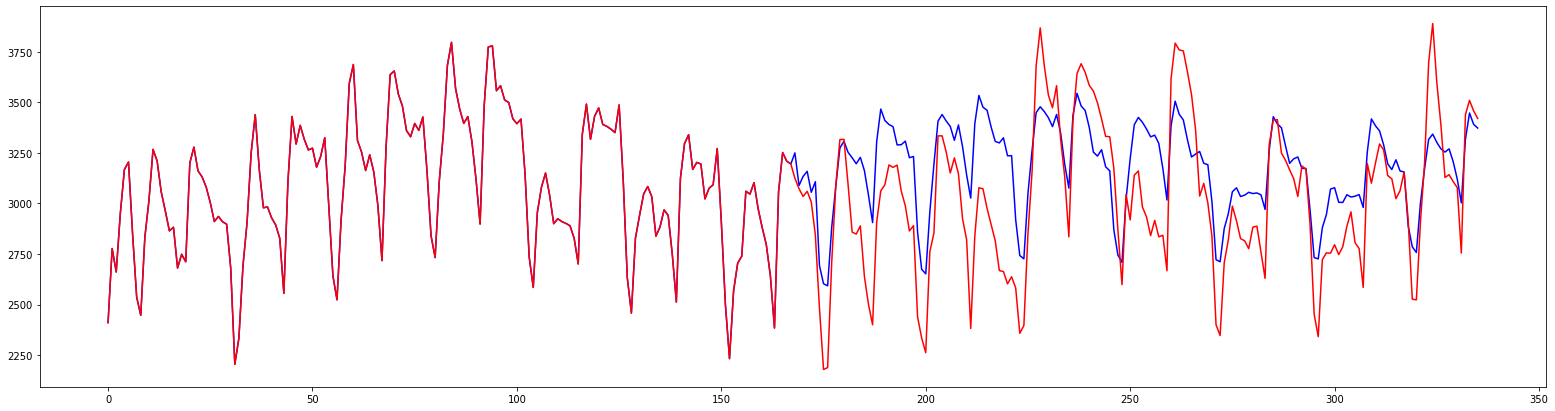

now : 5, sMAPE score : 7.722416444505571


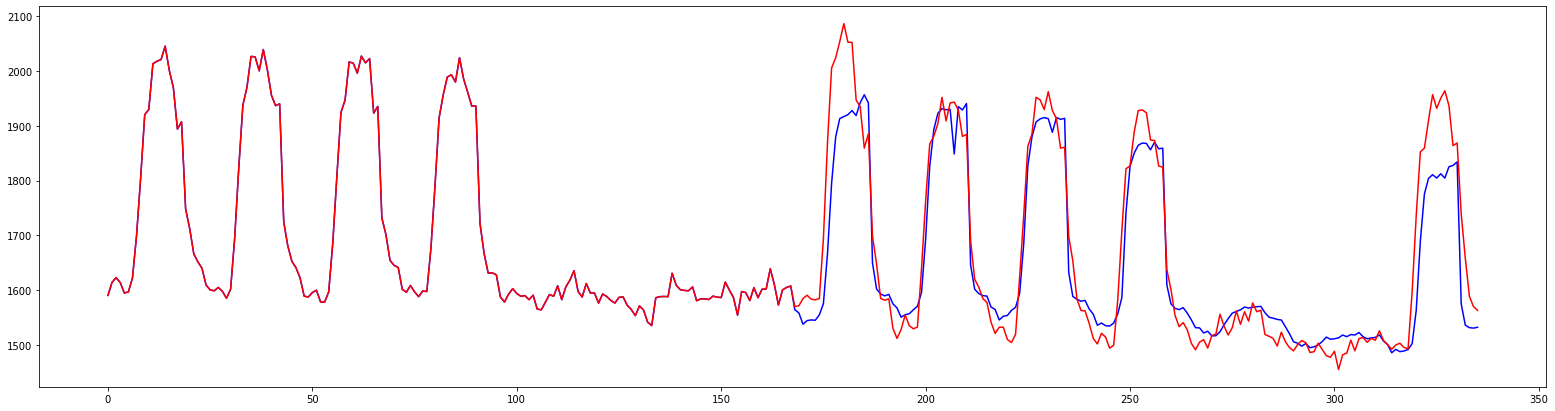

now : 16, sMAPE score : 2.4341567614469923


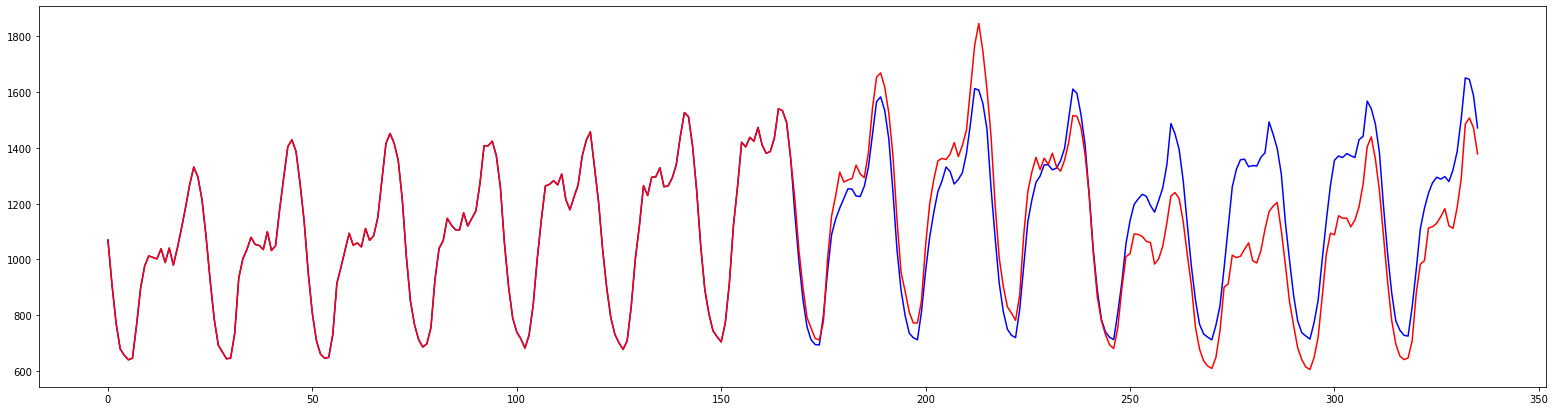

now : 19, sMAPE score : 10.709888501529973


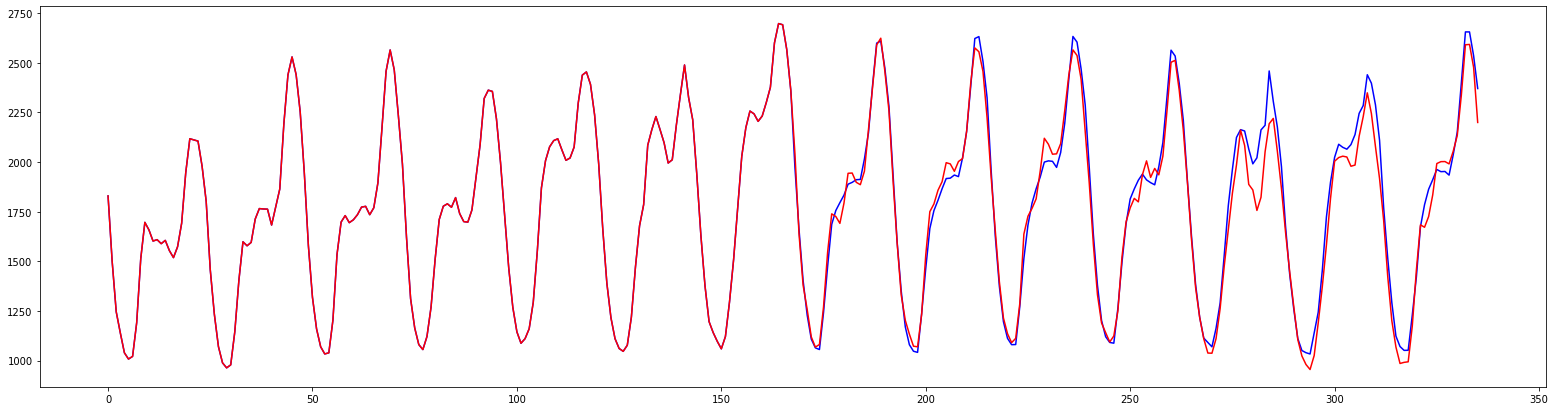

now : 20, sMAPE score : 3.333572917736619


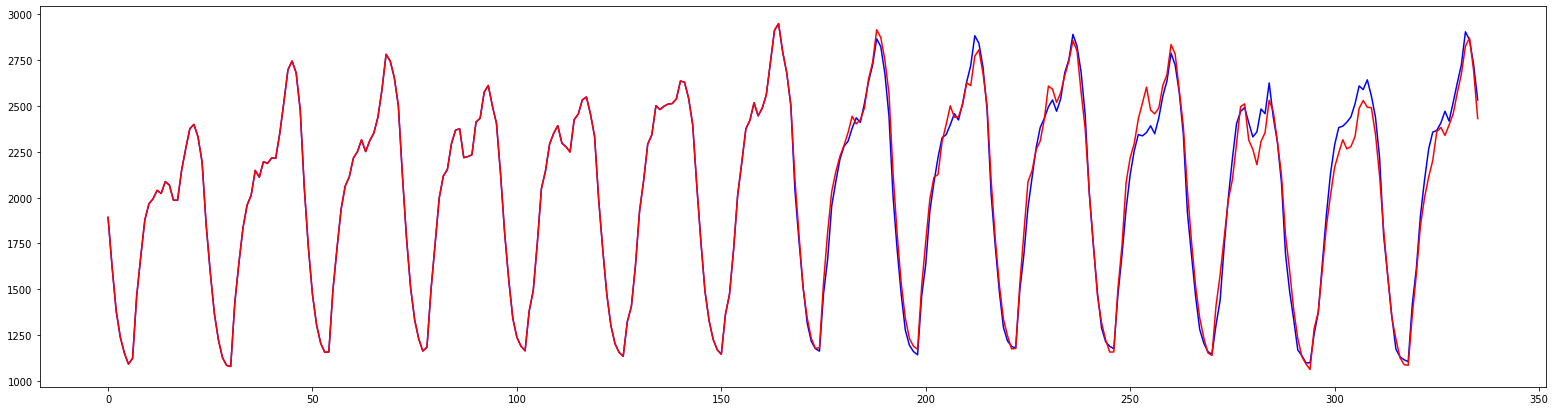

now : 21, sMAPE score : 2.938735716869312


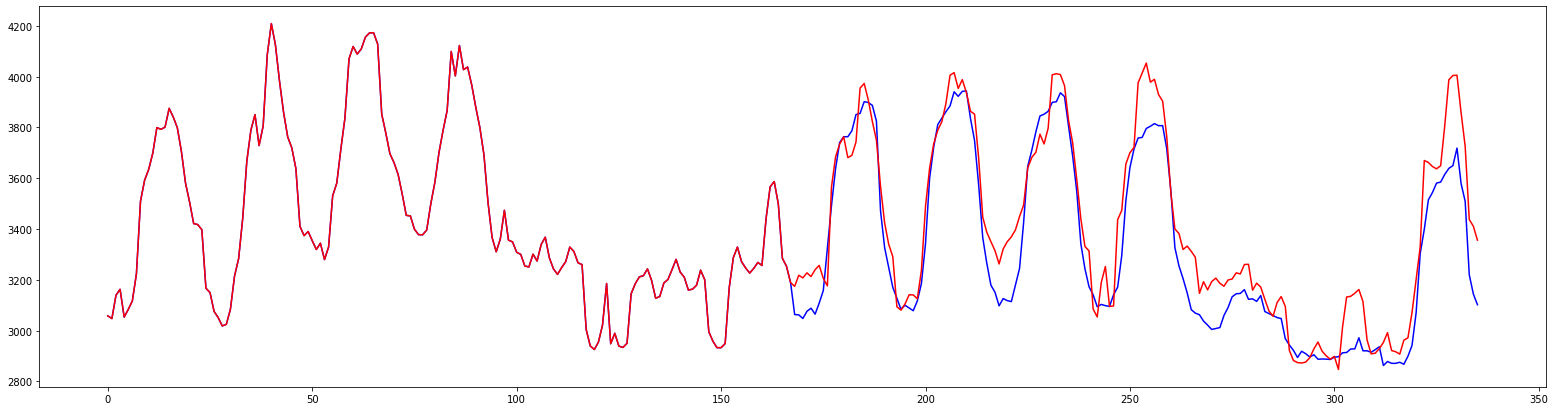

now : 24, sMAPE score : 3.0538466174454983


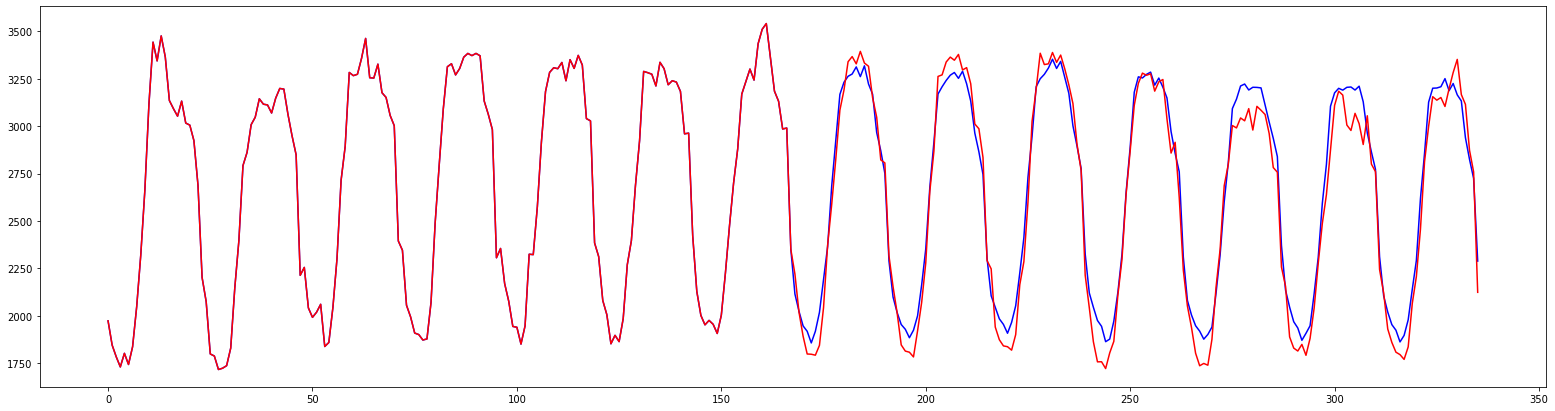

now : 28, sMAPE score : 3.5436566422442084


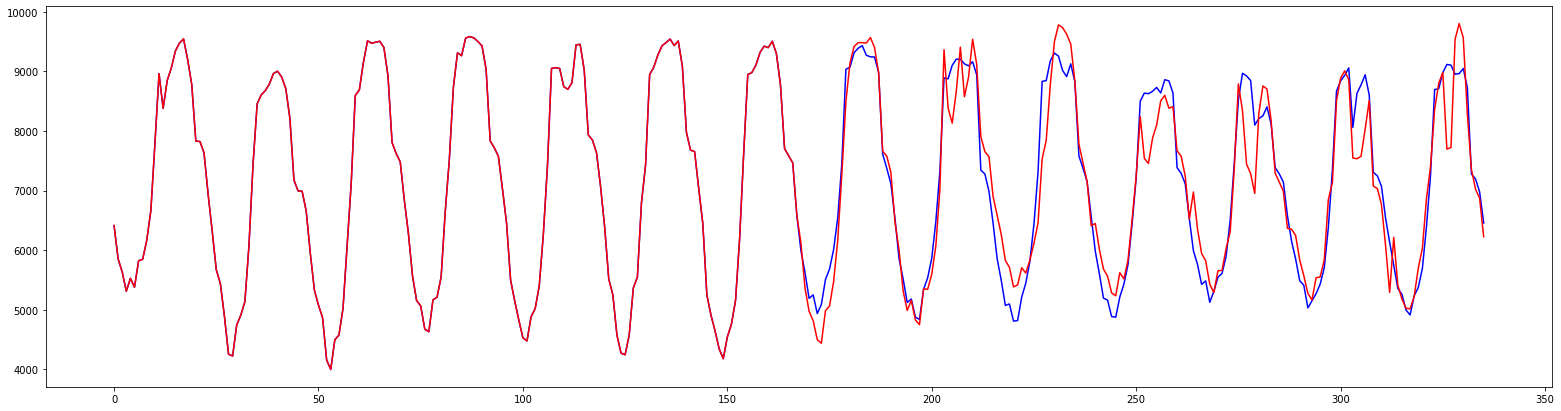

now : 30, sMAPE score : 5.2300854620719575


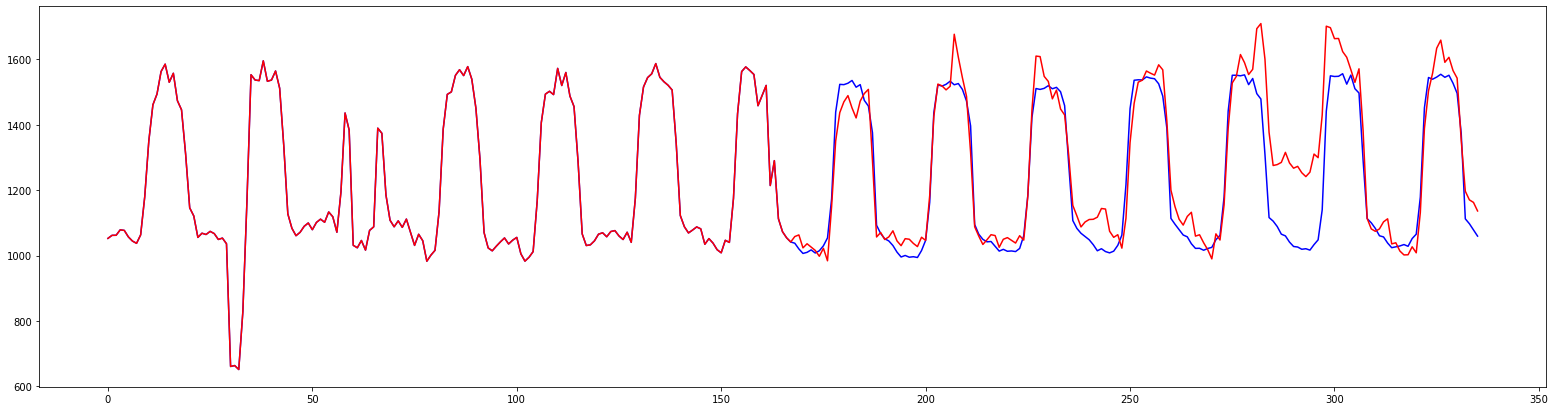

now : 36, sMAPE score : 5.129675528743072


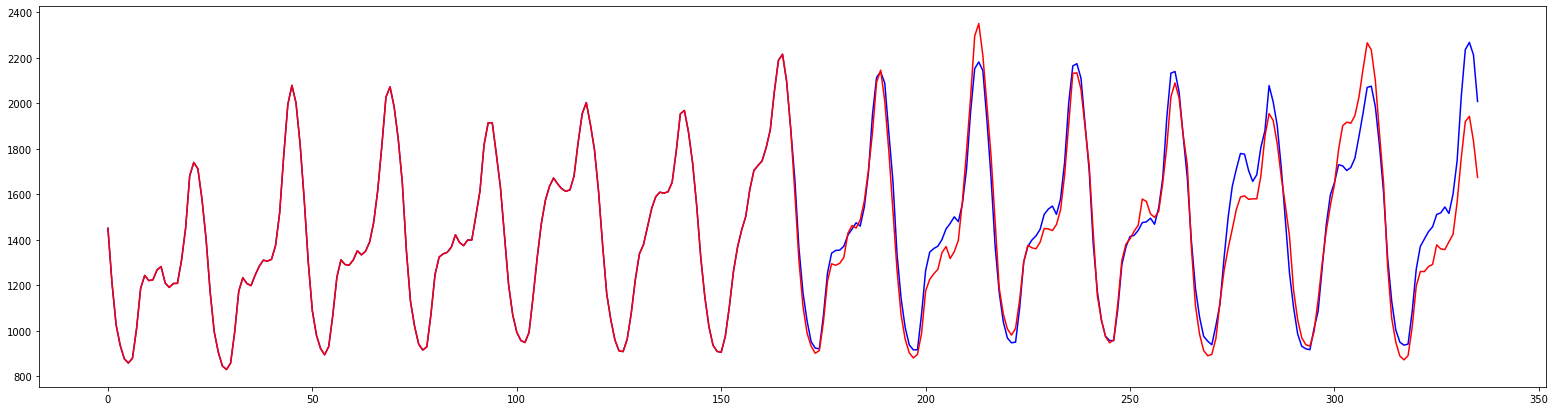

now : 49, sMAPE score : 5.167307146742699


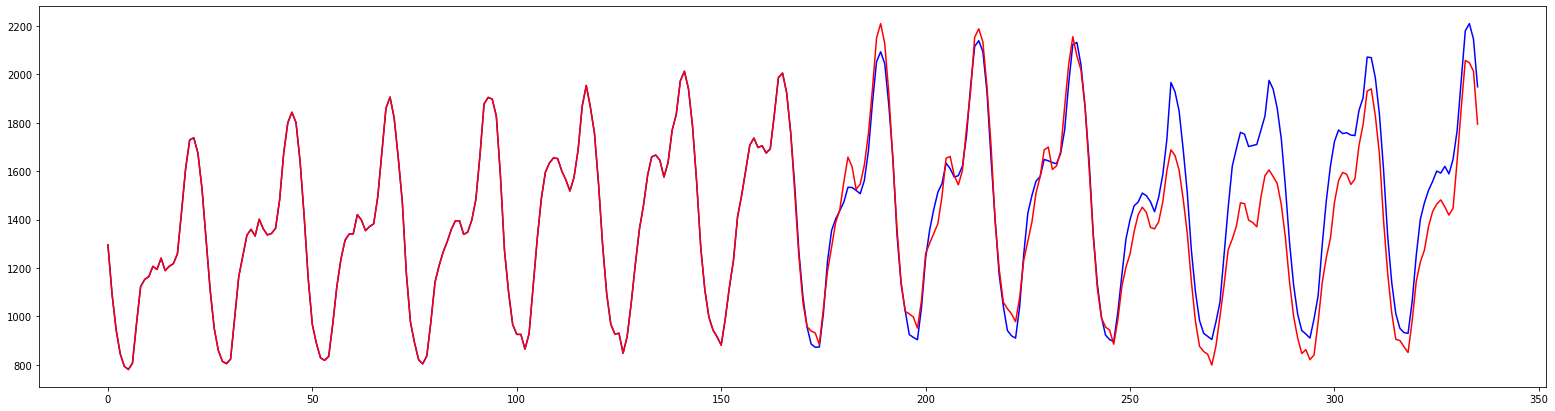

now : 50, sMAPE score : 7.4036686941300385


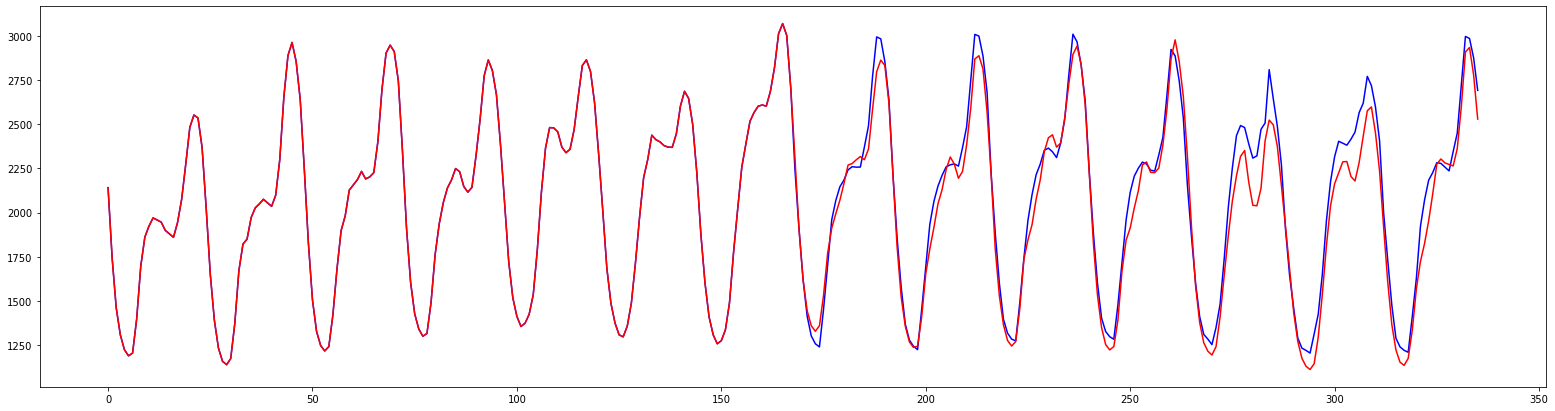

now : 51, sMAPE score : 4.491140778688611


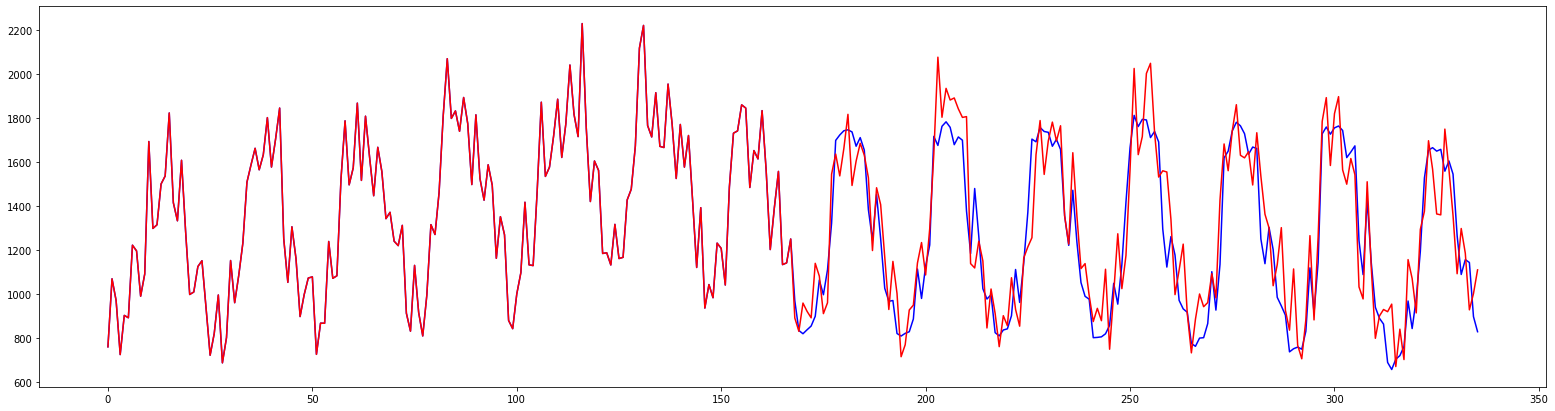

now : 59, sMAPE score : 10.446896574295081


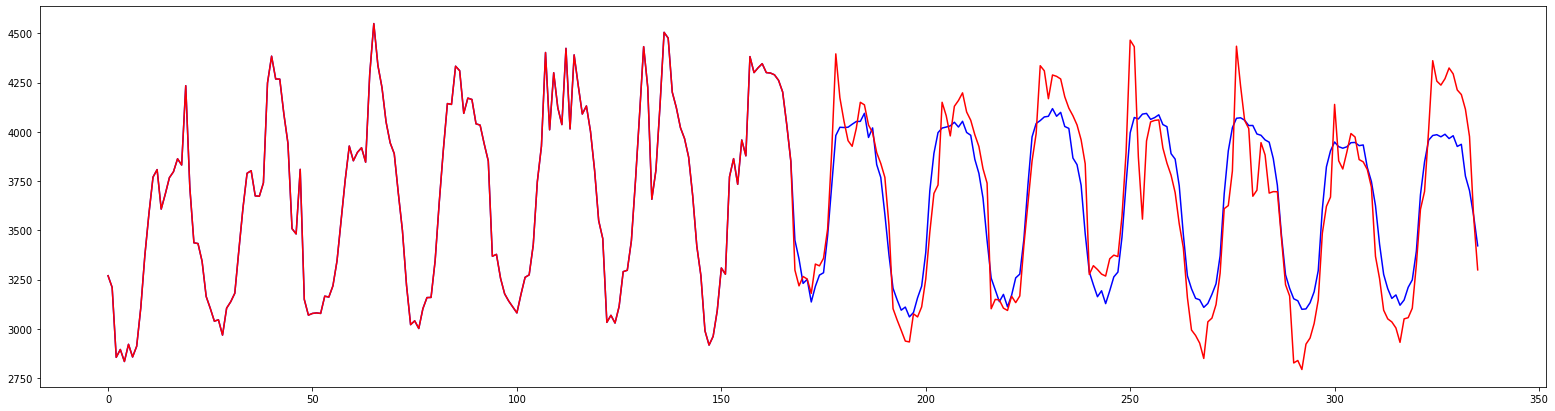

now : 60, sMAPE score : 3.9450122525273223
now step : 2, sMAPE score : 4.423916249567483


In [7]:
all_smape = []
all_record = {}

for i in range(len(building_num)):
    temp = pd.read_csv(data_paths[i], index_col=0)
    now_dataframe = temp.loc[temp["num"] == building_num[i]].copy()
    now_dataframe = now_dataframe[start_point:start_point+input_length+duration]

    now_dataframe['num'] = now_dataframe['num'].apply(str)
    now_dataframe['Week'] = now_dataframe['Week'].apply(str)
    now_dataframe['24Hour'] = now_dataframe['24Hour'].apply(str)
    now_dataframe['holiday'] = now_dataframe['holiday'].apply(str)
    now_dataframe['Weekend'] = now_dataframe['Weekend'].apply(str)
    if not checking_tag[i].isdigit():
        now_dataframe['energy_group'] = now_dataframe['energy_group'].apply(str)

    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    original = now_dataframe.iloc[0:input_length]["kWH"].tolist()
    prediction = now_dataframe.iloc[0:input_length]["kWH"].tolist()

    total_cycle = 1 + ((len(now_dataframe) - input_length - output_length) // output_length)

    for k in range(total_cycle):
        now_start_point = k*output_length

        encoder_data = now_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
        decoder_data = now_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
        new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

        # get prediction, original data
        raw_predictions= now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
        originals = now_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

        prediction.extend(raw_predictions)
        original.extend(originals)

        # for next step, change dataframe's original value to predicted value
        for p in range(output_length):
            now_dataframe.iloc[now_start_point+input_length+p, now_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
    
    if show_graph:            
        plt.rcParams["figure.figsize"] = (27,7)
        fig = plt.figure()
        graph = fig.add_subplot(1, 1, 1)
        graph.plot(prediction, color='blue')
        graph.plot(original, color='red')       
        plt.show()

    smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
    all_smape.append(smape_loss)
    all_record[f"{building_num[i]}"] = smape_loss
    print(f"now : {building_num[i]}, sMAPE score : {smape_loss}")

print(f"now step : {random_choice}, sMAPE score : {np.mean(np.array(all_smape))}")

In [8]:
print(f"now step : {random_choice}, sMAPE score : {np.mean(np.array(all_smape))}")

all_record_sorted = sorted(all_record.items(), key = lambda x:x[1], reverse=True)

for item in all_record_sorted:
    print(f"now : {item[0]}, sMAPE score : {item[1]}")

now step : 2, sMAPE score : 4.423916249567483
now : 10, sMAPE score : 11.816288744844604
now : 19, sMAPE score : 10.709888501529973
now : 59, sMAPE score : 10.446896574295081
now : 27, sMAPE score : 9.62615588269021
now : 7, sMAPE score : 8.544954812323347
now : 5, sMAPE score : 7.722416444505571
now : 18, sMAPE score : 7.643988036663278
now : 4, sMAPE score : 7.589991757093719
now : 50, sMAPE score : 7.4036686941300385
now : 40, sMAPE score : 7.029093033025488
now : 23, sMAPE score : 6.928604726511244
now : 42, sMAPE score : 6.6581639611146475
now : 41, sMAPE score : 6.436561865729861
now : 11, sMAPE score : 6.328478188813635
now : 56, sMAPE score : 5.913475122914479
now : 35, sMAPE score : 5.255056522004938
now : 30, sMAPE score : 5.2300854620719575
now : 25, sMAPE score : 5.200844957645447
now : 49, sMAPE score : 5.167307146742699
now : 15, sMAPE score : 5.15712433864981
now : 36, sMAPE score : 5.129675528743072
now : 48, sMAPE score : 5.099931984804866
now : 29, sMAPE score : 4.964